 ### Bayesian Statistics, Course Project 
# Kaggle challenge on particle physics
# Logistic regression with JAGS
### Minimally-targetted undersampling (OSS and NCR) implementations 


### Adrián Fernández Cid, Aitor Lucas Castellano, Marcos Moreno Blanco & Noel Rabella Gras
### 28-06-2021

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

This code reproduces the analysis presented in **CERN-RandomSamples-Logistic-JAGS.ipynb** but replacing the random undersampling by an undersampling consisting of a one-step targetted reduction (by One-Sided Selection or the Neighbourhood Cleaning Rule) followed by a further random undersampling to reduce the train data to the required size for processing with JAGS (roughly 2000 samples). 

Moreover, since the Horseshoe Prior did not prove useful in **CERN-RandomSamples-Logistic-JAGS.ipynb**, here we limit our treatment to the vanilla prior for the logistic regression.

## Outline
### 1. Data exploration
### 2. Vanilla logistic regression with OSS
#### 2.1. Modelling
#### 2.2. Evaluation 
### 3. Vanilla logistic regression with NCR
#### 3.1. Modelling
#### 3.2. Evaluation 
### 4. Conclusion

## 1. Data exploration

We have a tabular dataset with information on particle collisions recorded at the LHCb experiment at CERN, and the objective is to identify the presence of a specific process: **the decomposition of $B_0$ into $K^0$**. We therefore have a binary classification problem, in which the focus is placed on the pòsitive signal. This last point suggests we keep an eye on recall (also known as sensitivity) to maximise true postives.

Since the meaning of the predictors is not obvious, we include their description here:

**B_FDCHI2_OWNPV**: Flight distance of the B meson with respect to the primary vertex (point of proton-proton collision).

**B_IPCHI2_OWNPV**: Impact parameter. Shortest distance between the B meson trajectory and the primary vertex.

**B_PT**: B meson transverse momentum

**PIMINUS** & **KPLUS PSEUDORAPIDITY**: Angle of the piminus and Kplus particles with respect to the beam axis.

**KPLUS** & **PIMINUS P**: Kplus and piminus momentum.

**KST_892_0_COSTHETAH**: K* helicity angle. Angle formed bewteen one of the particle products of K* (piminus or Kplus) and the B meson in the reference frame of the K* (rest frame)
GAMMA_PT: photon transverse momentum.

**KST_892_0_IP_OWNPV**: Impact parameter of K*, which corresponds to the shortest distance between the K* trajectory and the primary vertex.

**B_OWNPV_CHI2**: Chi2 test of the primary vertex distribution.

**KPLUS** & **PIMINUS IP_OWNPV**: Shortest distance between the Kplus or the piminus trajectory and the primary vertex.

**B_DIRA_OWNPV**: Corresponds to the cosine of the angle formed by the momentum of the B meson and the vector formed between the initial (primary vertex) and final position (decay vertex) of the B meson.

The data, published code and other details of the challenge are available at:
https://www.kaggle.com/c/cernsignal/overview.



In [7]:
# load required packages for the whole notebook
require(mcsm)
require(bayesplot)
require(dplyr)
#install.packages("Epi",dependencies=TRUE,repos="https://cloud.r-project.org")
require(Epi)
#install.packages("corrplot",dependencies=TRUE,repos="https://cloud.r-project.org")
require(corrplot)
#install.packages("R2jags",dependencies=TRUE,repos="https://cloud.r-project.org")
require(R2jags)
#install.packages("pROC")
require(pROC)
#install.packages("unbalanced",dependencies=TRUE,repos="https://cloud.r-project.org")
require(unbalanced)

Loading required package: unbalanced

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: foreach

Loading required package: doParallel

Loading required package: iterators

Loading required package: parallel



Load labelled dataset (we will only use this):

In [8]:
train <- read.csv("data/train.csv")
names(train)
str(train)

[1] "Id"                  "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"     
 [4] "B_FDCHI2_OWNPV"      "B_DIRA_OWNPV"        "B_PT"               
 [7] "Kst_892_0_IP_OWNPV"  "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"     
[10] "Kplus_P"             "piminus_IP_OWNPV"    "piminus_P"          
[13] "gamma_PT"            "piminus_ETA"         "Kplus_ETA"          
[16] "BUTTER"              "signal"

'data.frame':	212662 obs. of  17 variables:
 $ Id                 : int  0 1 2 3 4 5 6 7 8 9 ...
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ BUTTER             : num  0.551 0.543 0.866 -0.443 -0.447 ...
 $ s

There are no NA (not available) values:

In [9]:
dim(train)
sum(is.na(train))
train=na.omit(train)
dim(train)
sum(is.na(train))

[1] 212662     17

[1] 0

[1] 212662     17

[1] 0

Remove **Id** (just an index) and **BUTTER** (an irrelevant column with butter consumption in Switzerland, purposely placed as a test). All other columns are numeric, so no need to factor any of them nor for a subsequent one-hot encoding.

In [10]:
data <- select(train, -Id
               , -BUTTER
              )
# rename "signal" column to fit the rest of the code
names(data)[names(data) == 'signal'] <- 'Response'
str(data)

'data.frame':	212662 obs. of  15 variables:
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ Response           : num  1 1 1 0 0 0 1 0 0 0 ...


As commented on in **CERN-RandomSamples-Logistic-JAGS.ipynb**, the variable **B_DIRA_OWNPV** seems to have little variability and therefore contain little information, but we won't remove it for the sake of comparison.

In [11]:
summary(data$B_DIRA_OWNPV)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9995  1.0000  1.0000  1.0000  1.0000  1.0000 

Another thing we should do is check the correlation between predictors (i.e. colinearity, which is invariant under centering and scaling). One should do it for all the available data, so we obtain a suitable dataframe:

In [75]:
colnames(data)[15]

[1] "Response"

In [76]:
x.corr<-model.matrix(Response~.,data)[,-1]
cn<-colnames(x.corr)
x.corr<-cbind(x.corr, data[, 15]) # add Response column
colnames(x.corr)<-c(cn, "Response")
str(x.corr)
#head(x.corr)

 num [1:212662, 1:15] 28.9 34.2 36.1 14.3 60.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:212662] "1" "2" "3" "4" ...
  ..$ : chr [1:15] "B_OWNPV_CHI2" "B_IPCHI2_OWNPV" "B_FDCHI2_OWNPV" "B_DIRA_OWNPV" ...


Note we have included the response in x.corr. this will give us a first hint of which predictors are most important for the classification. The plot of the correlation matrix is:

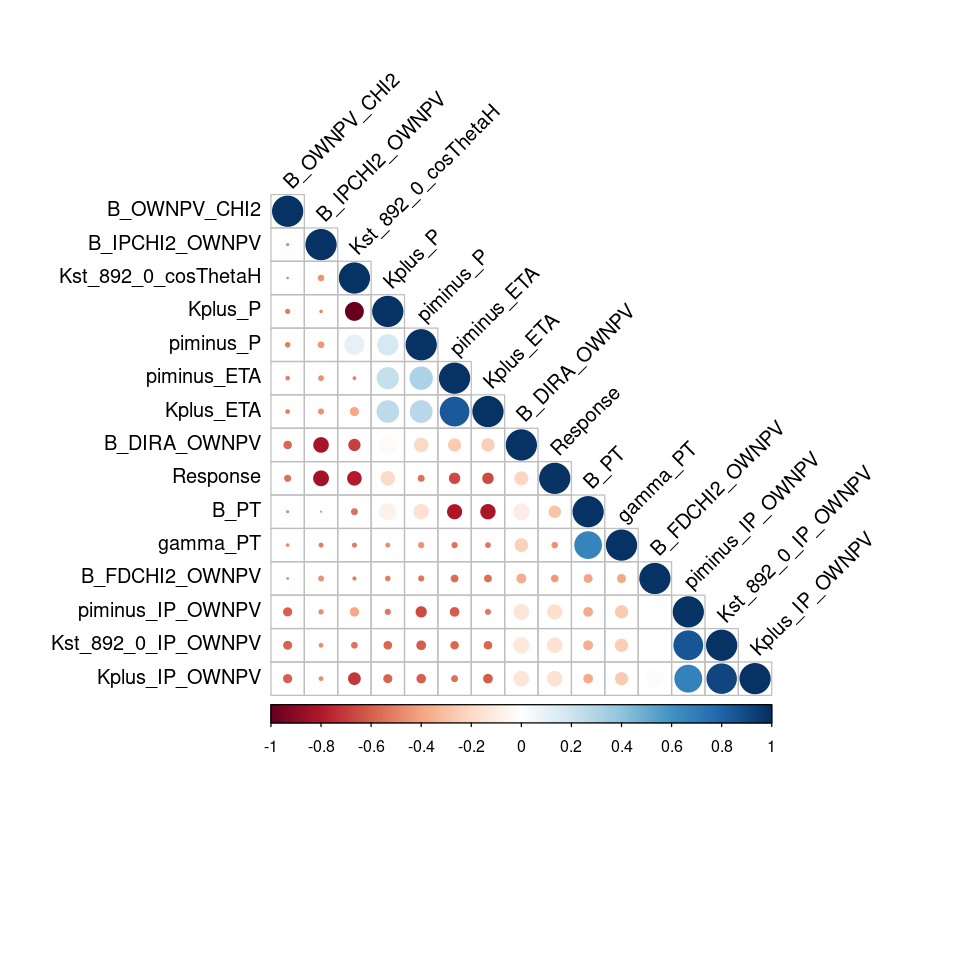

In [77]:
options(repr.plot.width=8,repr.plot.height=8)
corrplot(cor(x.corr), type="lower", order="hclust", tl.col="black", tl.srt=45)

Looks like we have remarkable positive correlation in the pairs **piminus_ETA/Kplus_ETA**, **B_PT/gamma_PT** and the triplet **piminus_IP_OWNPV/Kst_892_0_IP_OWNPV/Kplus_IP_OWNPV**, and negative correlation in the pairs **Kplus_P/Kst_892_0_cosThetaH**, **Kplus_IP_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/B_IPCHI2_OWNPV**, **B_PT/piminus_ETA** and **B_PT/Kplus_ETA**.

Regarding the response, it has strong negative correlation with **Kst_892_0_cosThetaH** and with **B_IPCHI2_OWNPV**.

Note the signal (presence of the process of interest $\equiv$ 1) is sparse:

In [12]:
n<-length(data$Response)
n
n1<-sum(data$Response)
n1
f<-n1/n
round(f,3)


[1] 212662

[1] 71030

[1] 0.334

Let us implement the undersampling. We define a function similar to *subsample.balanced* in **CERN-RandomSamples-Logistic-JAGS.ipynb**, but with the additional option for the one-step targetted removal:

In [66]:
subsample.balanced.2<-function(df, method="oss", nh=1000, seed=NULL){
    if (!is.null(seed)){set.seed(seed)}  # for reproducibility
    
    X<-select(df, -Response)
    Y<-df$Response

    #targetted removal
    if (method=="oss"){
        cat("\nOSS undersampling:\n")
        subsample.targ<-ubOSS(X, Y, verbose = TRUE)
        X<-subsample.targ$X
        Response<-subsample.targ$Y
        train.sub<-cbind(X, Response)
    }
    else if (method=="ncr"){
        cat("\nNCR undersampling:\n")
        subsample.targ<-ubNCL(X, Y, verbose = TRUE)
        X<-subsample.targ$X
        Response<-subsample.targ$Y
        train.sub<-cbind(X, Response)
    }
    else if (method=="random"){
        train.sub<-df
    }
    else {
        stop("\nPlease choose an available method ('oss', 'ncr' or 'random')\n")
    }

    positives<-train.sub[train.sub$Response==1,]
    negatives<-train.sub[train.sub$Response==0,]

    # randomly (uniform dist) pick number of rows equal to half size nh 
    #from  all the rows of data and store the row number
    #positive subsamples
    pos.ind <-sample(as.integer(row.names(positives)), size=nh)
    #negative subsamples
    neg.ind <-sample(as.integer(row.names(negatives)), size=nh)
    #final train and test subsets
    train.ind<-c(pos.ind, neg.ind)
    sample.train <- df[train.ind,]
    sample.test <- df[-train.ind,]  
    cat("\nFinal subset: \nTrain size =", dim(sample.train)[1], "\nTest size =",
        dim(sample.test)[1], "\nTrain signal fraction =",
        sum(sample.train$Response)/dim(sample.train)[1])
    
    return(list("train"=sample.train, "test"=sample.test))
    }

## 2. Vanilla logistic regression with OSS


As before, we take as large a subsample as we reasonably can (2000 samples takes us around 40 min to process with JAGS -which we do a total of 6 times-, so we settle for that number) and repeat the process another 2 times for consistency checks (all with a fixed seed, for reproducibility). We therefore take our 3 different subsamples:

In [68]:
method="oss"
nh<-1000#50

In [69]:
subsample.01 <- subsample.balanced.2(data, method=method, nh=nh, seed=4)
train.01<-subsample.01$train
test.01<-subsample.01$test
#str(train.01)
#str(test.01)
subsample.02 <- subsample.balanced.2(data, method=method, nh=nh, seed=44)
train.02<-subsample.02$train
test.02<-subsample.02$test

subsample.03 <- subsample.balanced.2(data, method=method, nh=nh, seed=444)
train.03<-subsample.03$train
test.03<-subsample.03$test


OSS undersampling:
Instances removed 33928 : 23.96 % of 0 class ; 15.95 % of training ; Time needed 1.5 
Train size = 2000 
Test size = 210662 
Train signal fraction = 0.5
OSS undersampling:
Instances removed 33928 : 23.96 % of 0 class ; 15.95 % of training ; Time needed 1.71 
Train size = 2000 
Test size = 210662 
Train signal fraction = 0.5
OSS undersampling:
Instances removed 33928 : 23.96 % of 0 class ; 15.95 % of training ; Time needed 1.39 
Train size = 2000 
Test size = 210662 
Train signal fraction = 0.5

And format them for JAGS:

In [70]:
# Convert factors to one-hot indicators
x.01<-model.matrix(Response~.,train.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
y.01<-train.01$Response
#check x.01 is indeed ohe'd (eg see "Vehicle_Age")
#head(x.01)
x.02<-model.matrix(Response~.,train.02)[,-1] 
y.02<-train.02$Response

x.03<-model.matrix(Response~.,train.03)[,-1] 
y.03<-train.03$Response

As we have seen in class, non-standardised data yields instability, so let us standardise x. Again, for agility, we define a function to do it:

In [72]:
standardise<-function(x){
    #compute means of every column (2 for columns, 1 for rows)) of X
    xm<-apply(x,2,mean)
    # center each column by substracting its mean
    xc<-sweep(x,2,xm,"-")
    # get standard dev of columns of xc
    xs<-apply(xc,2,sd)
    # standardise xc by dividing each column by its sd
    x0<-sweep(xc,2,xs,"/")
    return(x0)}

In [73]:
x0.01<-standardise(x.01)
x0.02<-standardise(x.02)
x0.03<-standardise(x.03)
#head(x0.01)
# check that all vertical means of x0.01 are indeed 0
round(max(abs(apply(x0.01,2,mean))),6) 
# check that indeed sd's of columns of x0.01 are 1
round(apply(x0.01,2,sd), 5)

[1] 0

B_OWNPV_CHI2      B_IPCHI2_OWNPV      B_FDCHI2_OWNPV        B_DIRA_OWNPV 
                  1                   1                   1                   1 
               B_PT  Kst_892_0_IP_OWNPV Kst_892_0_cosThetaH      Kplus_IP_OWNPV 
                  1                   1                   1                   1 
            Kplus_P    piminus_IP_OWNPV           piminus_P            gamma_PT 
                  1                   1                   1                   1 
        piminus_ETA           Kplus_ETA 
                  1                   1

The condition number $\kappa$ is indeed much smaller after standardisation, meaning a more stable regression:

In [74]:
#have to take the intercept into account as well for the condition number
x1.01<-cbind(rep(1,n),x.01)
x01.01<-cbind(rep(1,n),x0.01)
round(kappa(x1.01),1)
round(kappa(x01.01),1)

[1] 1120393977

[1] 14.2

### 2.1. Modelling

As in Week 12's *GLM.01.Logistic.Challenger.ipynb*, we have centered Gaussian priors for the logistic coefficients $\beta_i$, all with $\sigma = 10$, thus precision $\tau = 0.01$ (the same we use in the horseshoe case for $\beta_0$, for the sake of comparison). The likelihood of the logistic regression is, as seen in the mentioned notebook, a Bernoulli distribution with probability $p_i$ given by the logistic function. More graphically:

$$
    \begin{array}{lclcll}
        y_{i}           &\sim    &Bern(p_i),&&&1\leq i\leq n,\\[0.2cm]
         p_i &=      &\operatorname{Logistic}(\eta_i) =\dfrac{\exp(\eta_i)}{1+\exp(\eta_i)},&&&1\leq i\leq n,\\[0.2cm]
        \eta_{i}         &=     &\beta_{0}+x_{i\,\cdot\,}\cdot \beta,\mskip45mu  &&&1\leq i\leq n,\\[0.2cm]
        \beta_{j}        &\sim   &\normaldist(0,1.0E01), &&0\leq j\leq p,\\[0.2cm]
    \end{array}
$$


Define the JAGS model (very similar to what we did with the Challenger data):

In [78]:
model_string<-"
    model {
  
    #Priors
    b0 ~ dnorm(0.0,1.0E-2)
    for (j in 1:n_pars) {
        b[j] ~ dnorm(0.0,1.0E-2)
        }

    # Likelihood
    for (i in 1:n){
        y[i] ~ dbern(p[i])
        #logit(p[i]) <- eta[i]
       
        # logit(p[i]) <- max(-20,min(20,eta[i])) used to avoid numerical instabilities
        p[i] <- 1/(1+exp(-eta[i])) # can use for logit(p[i]) above
        
        eta[i] <- b0 + inprod(b[],X[i,])
        LLi[i] <- y[i] * log(p[i]) + (1 - y[i]) * log(1 - p[i])
    }
    
    # compute loglikelihood, deviance, AIC and BIC
    LogL <- sum(LLi[1:n])
    Deviance <- -2 * LogL            
    AIC <- -2 * LogL + 2 * (n_pars+1)   #total number of params = n_pars+1
    BIC <- -2 * LogL + logn * (n_pars+1)
  }
"

Define parameters and data (this one for each initial subsample), and the corresponding models:

In [79]:
n<-length(y.01)
p=dim(x0.01)[2]
params <- c("b0", "b", "LogL", "AIC", "BIC", "Deviance")

data.01 <- list(y = y.01, X = x0.01, n_pars = p, n = n, logn=log(n))
data.02 <- list(y = y.02, X = x0.02, n_pars = p, n = n, logn=log(n))
data.03 <- list(y = y.03, X = x0.03, n_pars = p, n = n, logn=log(n))


In [80]:
model.01<-jags.model(textConnection(model_string),data=data.01)
model.02<-jags.model(textConnection(model_string),data=data.02)
model.03<-jags.model(textConnection(model_string),data=data.03)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2000
   Unobserved stochastic nodes: 15
   Total graph size: 56034

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2000
   Unobserved stochastic nodes: 15
   Total graph size: 56034

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2000
   Unobserved stochastic nodes: 15
   Total graph size: 56034

Initializing model



Run one chain per model with 20 000 iterations and a burnout of the 5000 (see summary(sample.01)) initial samples (those that will be discarded to assure randomness of MCMC sampling). Note that this takes around 40 min for each of the three subsamples.

We could have defined initial values for the parameters, but as we have seen in the course JAGS can make a judicious choice thereof from the data, so we let it do it for us.

In [81]:
update(model.01, 4000, progress.bar = "gui")
update(model.02, 4000, progress.bar = "gui")
update(model.03, 4000, progress.bar = "gui")

In [82]:
start.time <- Sys.time()

sample.01<-coda.samples(model.01, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 41.54092 mins

In [83]:
start.time <- Sys.time()

sample.02<-coda.samples(model.02, variable.names = params,
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 39.72794 mins

In [84]:
start.time <- Sys.time()

sample.03<-coda.samples(model.03, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 39.83886 mins

Visualise output:

In [85]:
summary(sample.01)


Iterations = 5001:25000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean      SD  Naive SE Time-series SE
AIC       2.151e+03 5.53695 0.0391522      0.1162667
BIC       2.235e+03 5.53695 0.0391522      0.1162667
Deviance  2.121e+03 5.53695 0.0391522      0.1162667
LogL     -1.061e+03 2.76848 0.0195761      0.0581333
b[1]     -6.477e-02 0.05457 0.0003859      0.0004995
b[2]     -6.103e-01 0.06105 0.0004317      0.0007046
b[3]     -6.170e-01 0.23224 0.0016422      0.0037034
b[4]      5.606e-02 0.06745 0.0004769      0.0008770
b[5]     -5.336e-01 0.19582 0.0013846      0.0086744
b[6]     -3.201e-01 0.37097 0.0026232      0.0249567
b[7]     -2.261e-01 0.10198 0.0007211      0.0029619
b[8]      7.193e-01 0.27580 0.0019502      0.0164129
b[9]      1.274e+00 0.14229 0.0010061      0.0050291
b[10]     5.925e-01 0.20558 0.0014537      0.0093236
b[11] 

In [86]:
#summary(sample.02)

In [87]:
#summary(sample.03)

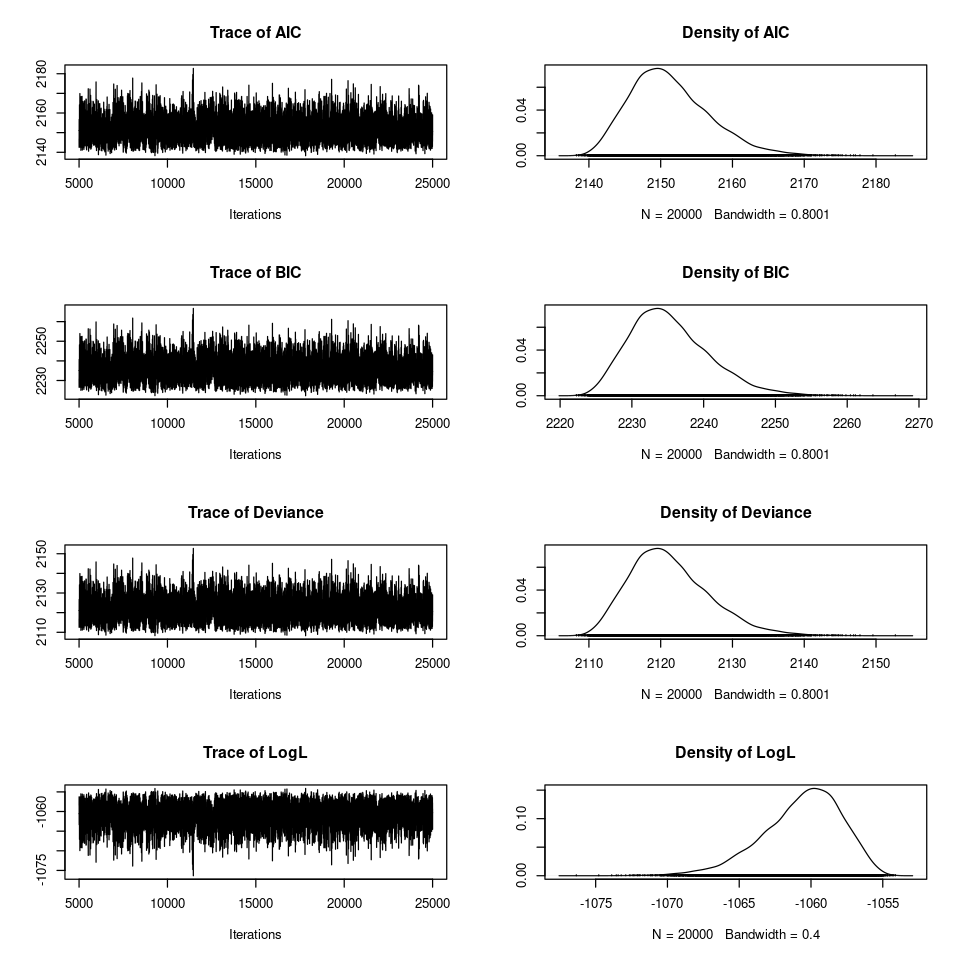

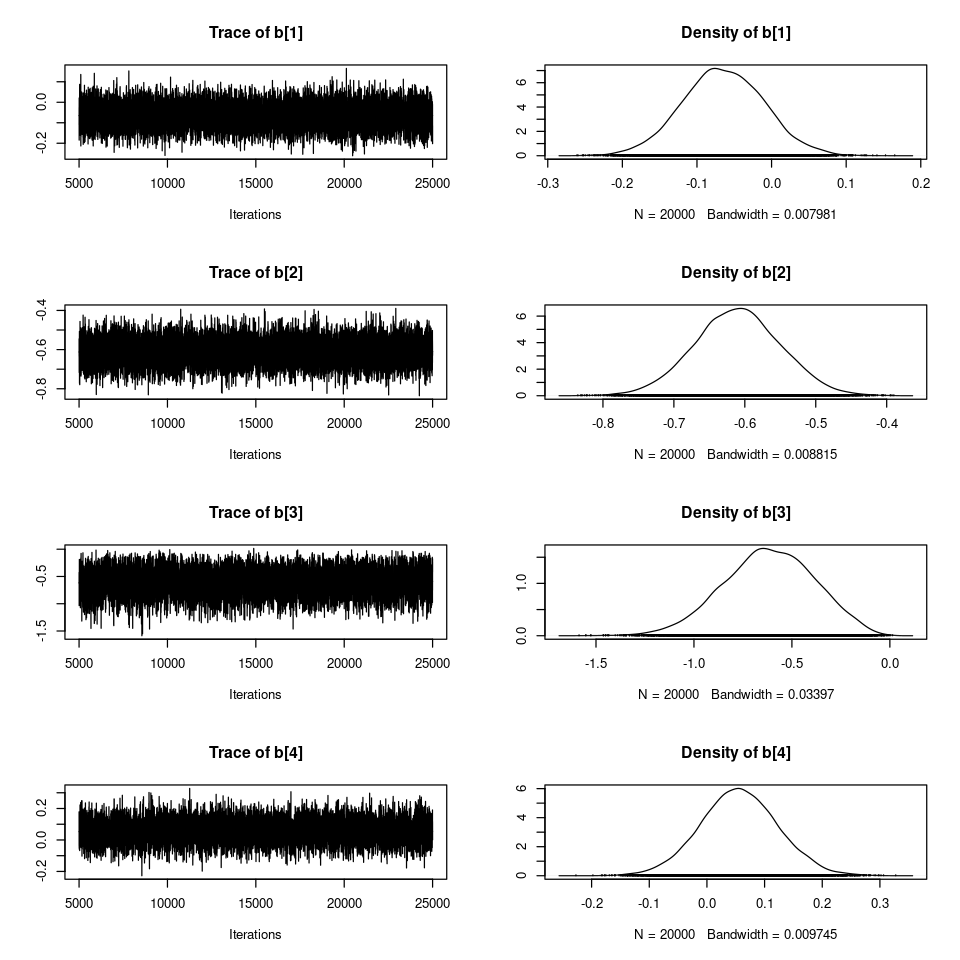

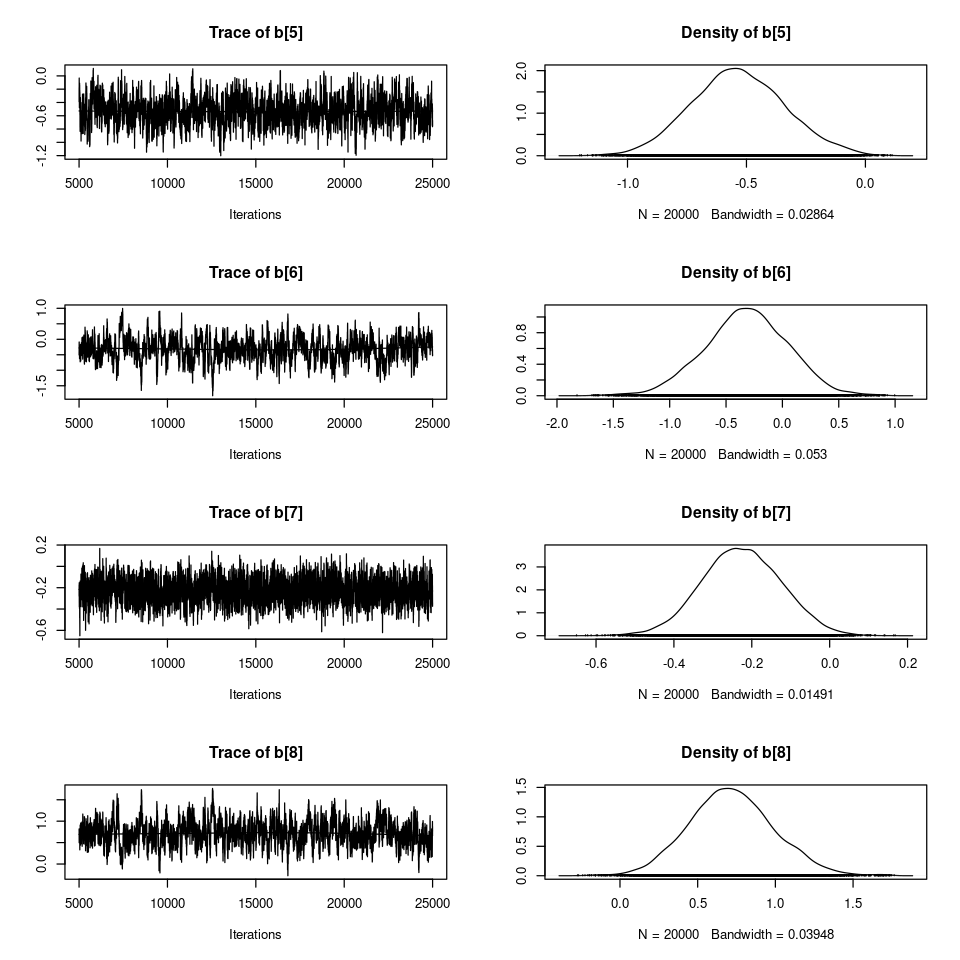

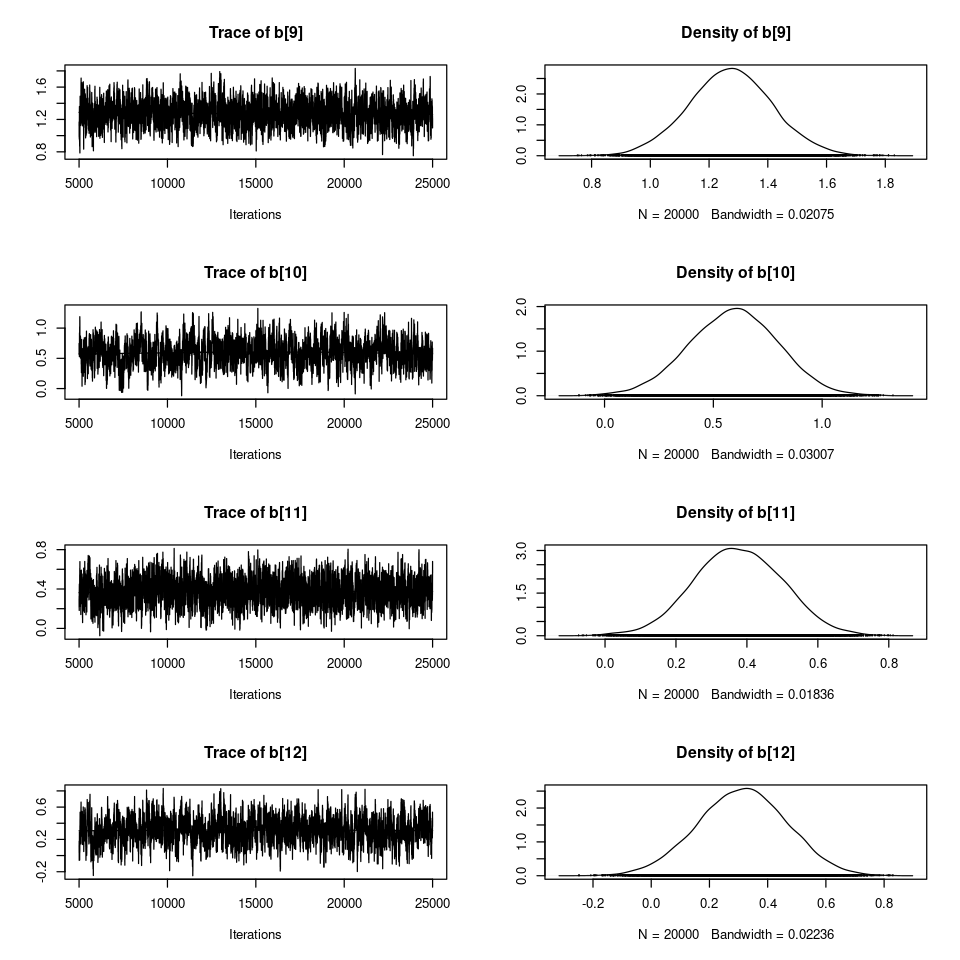

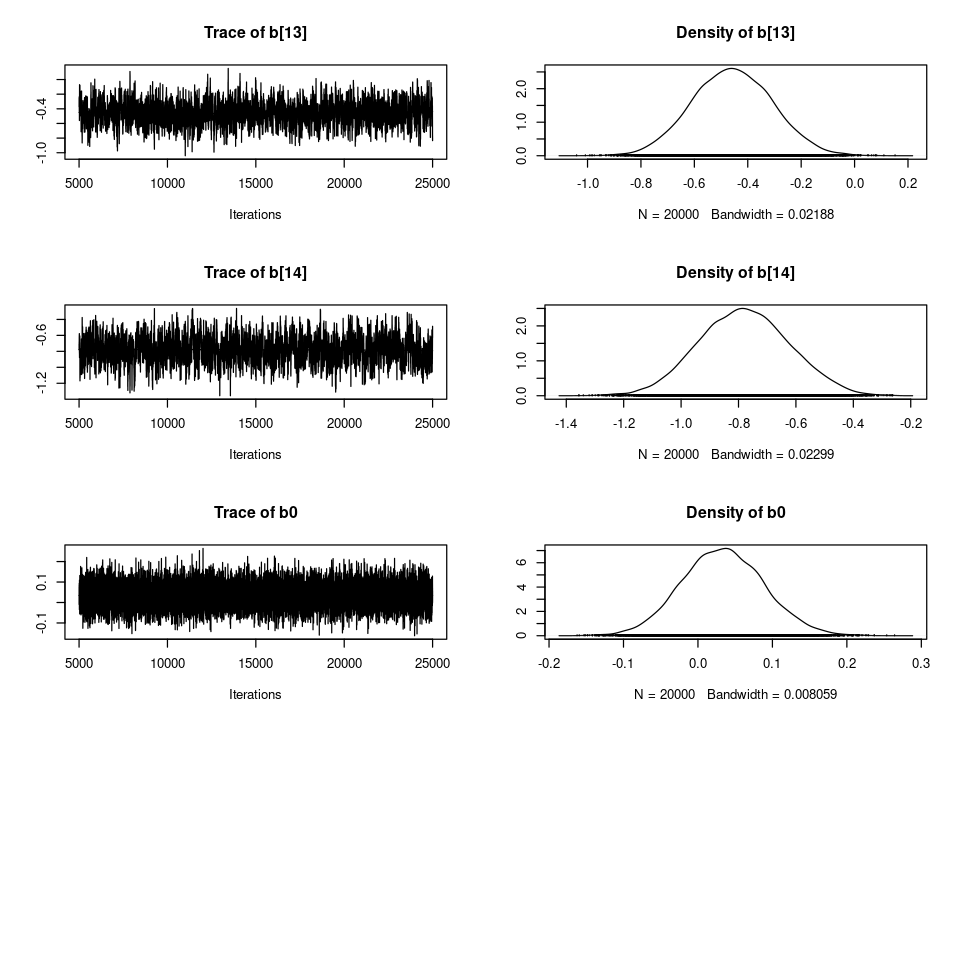

In [88]:
plot(sample.01)

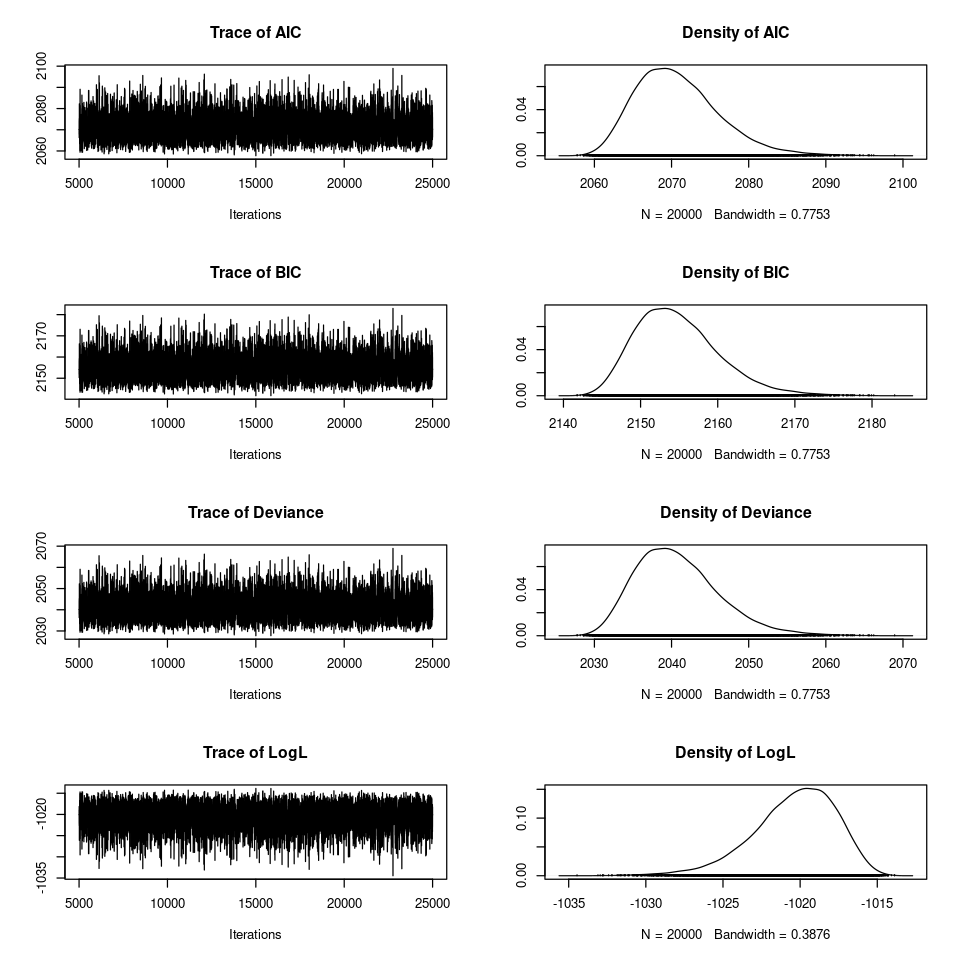

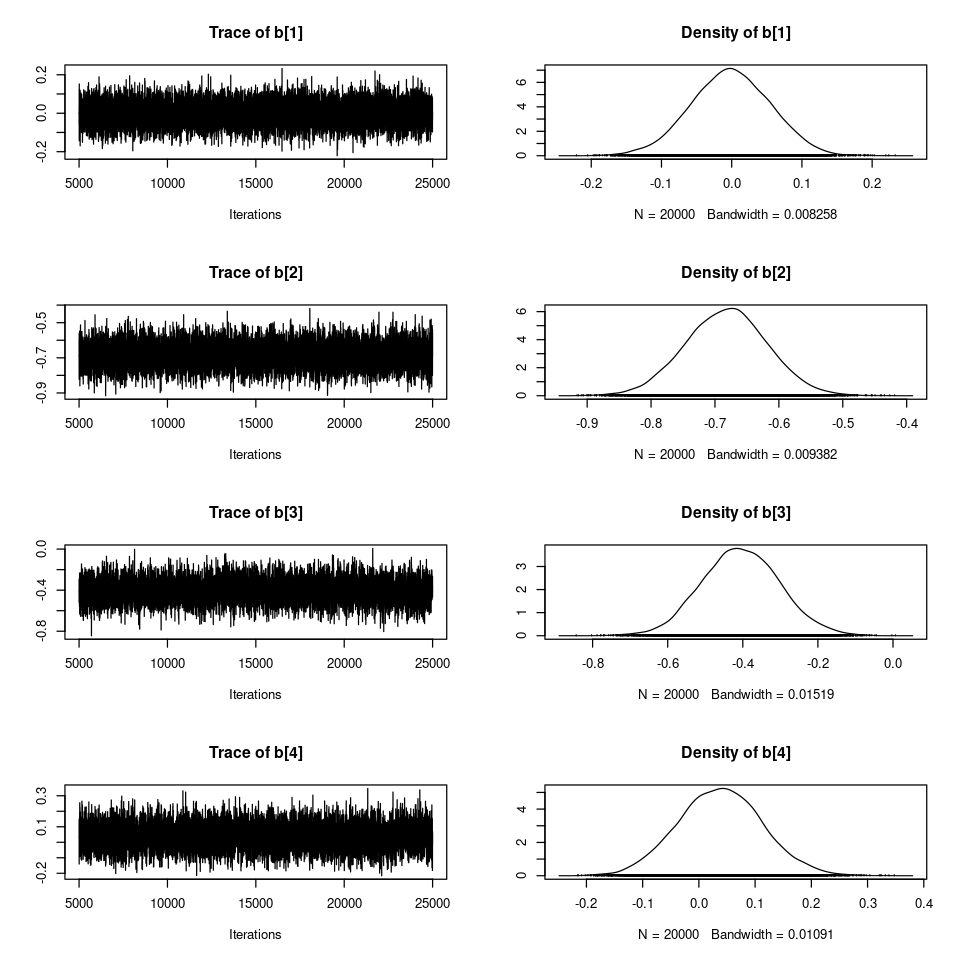

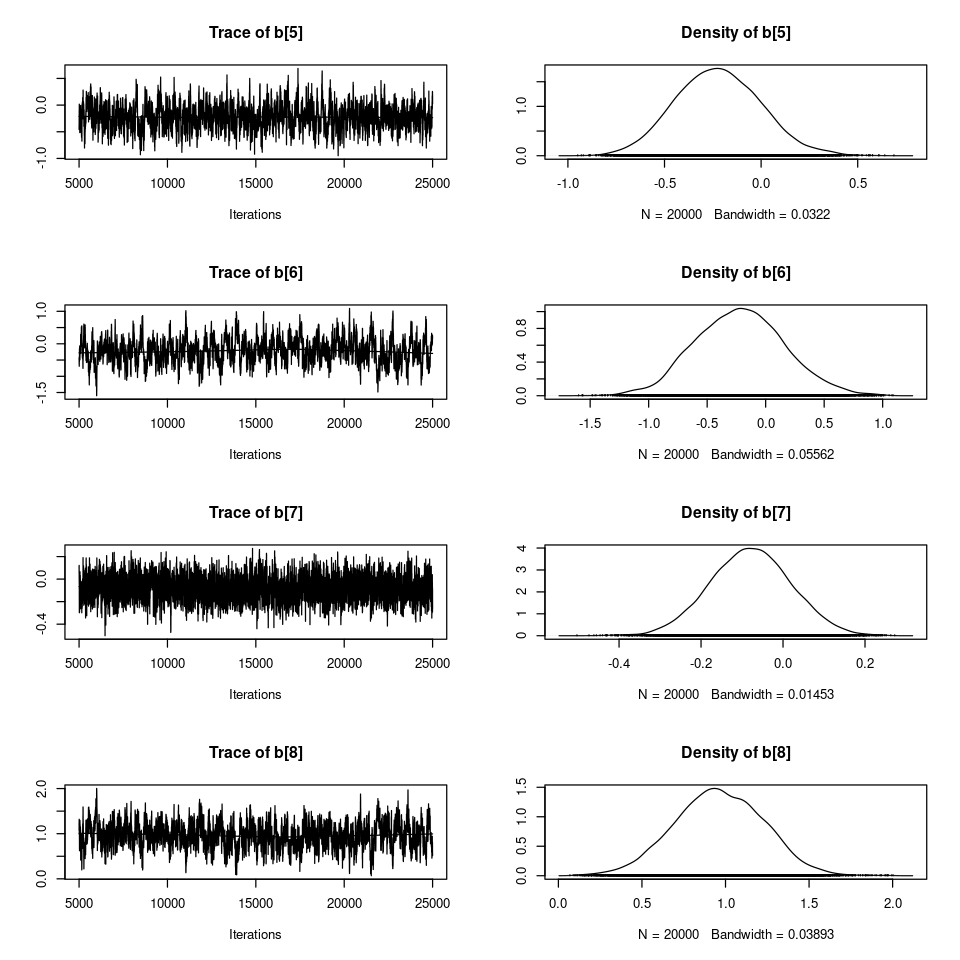

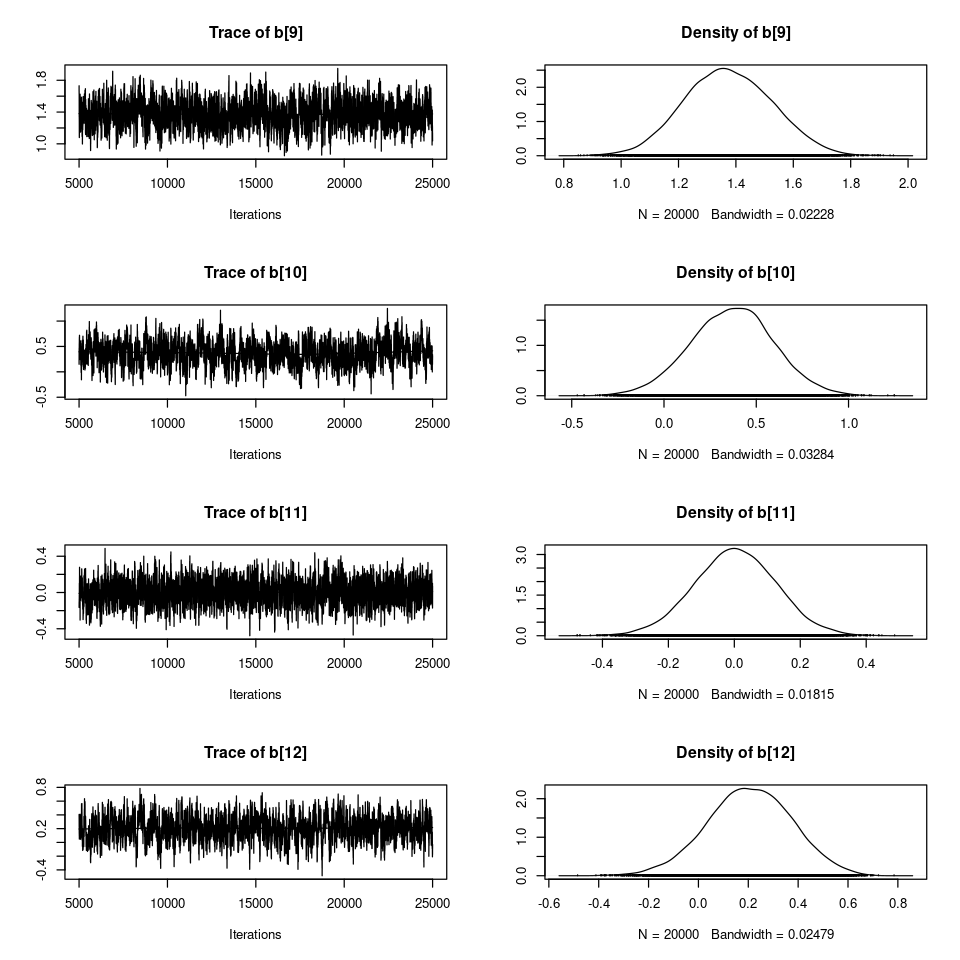

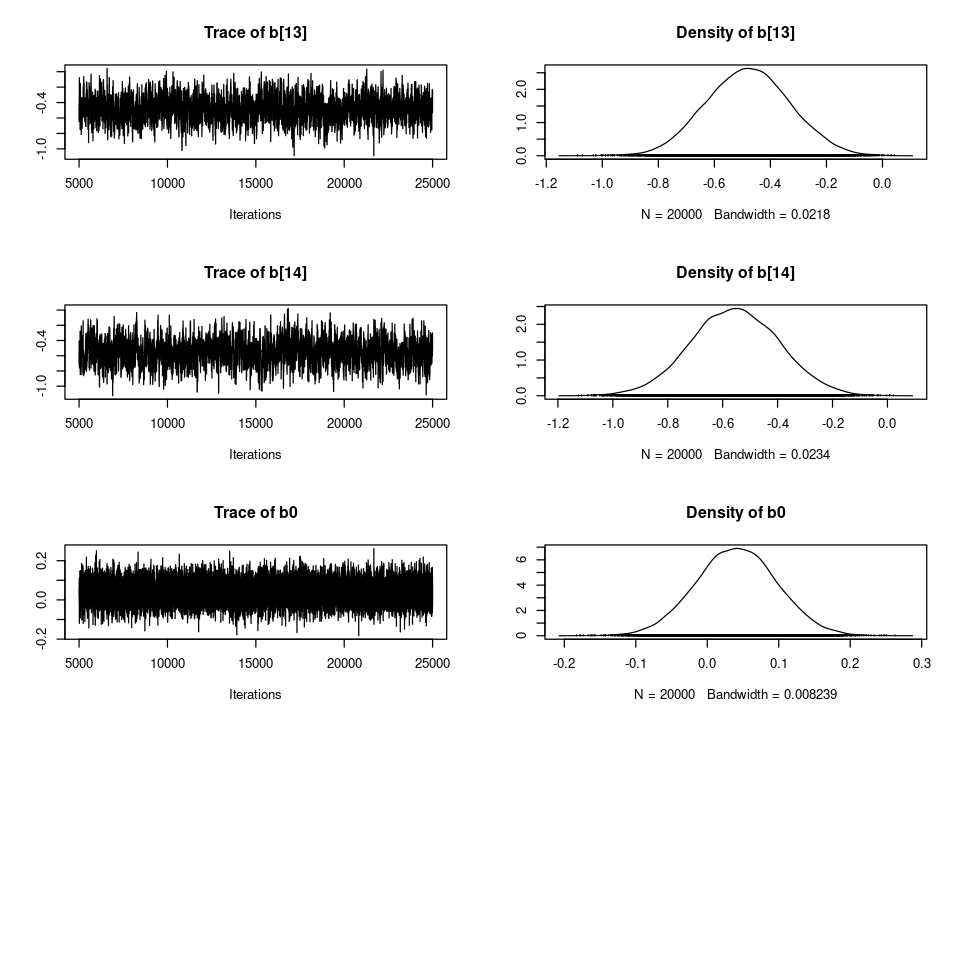

In [89]:
plot(sample.02)

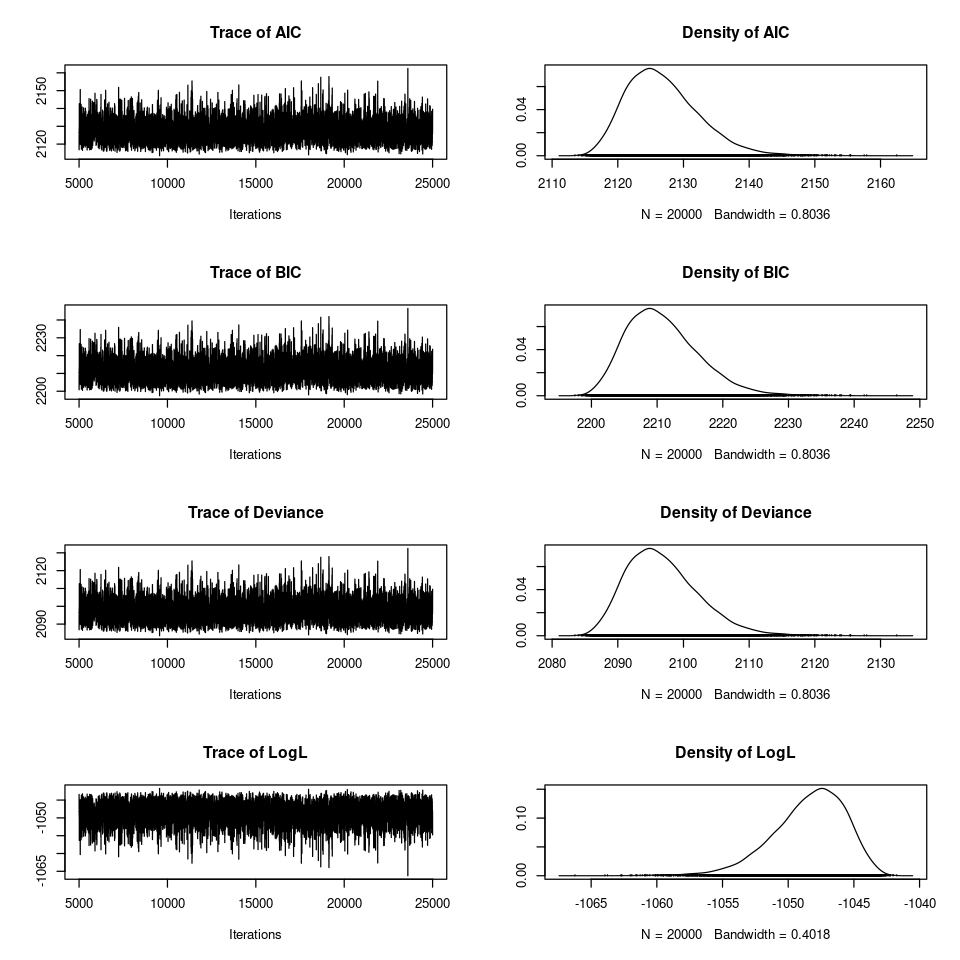

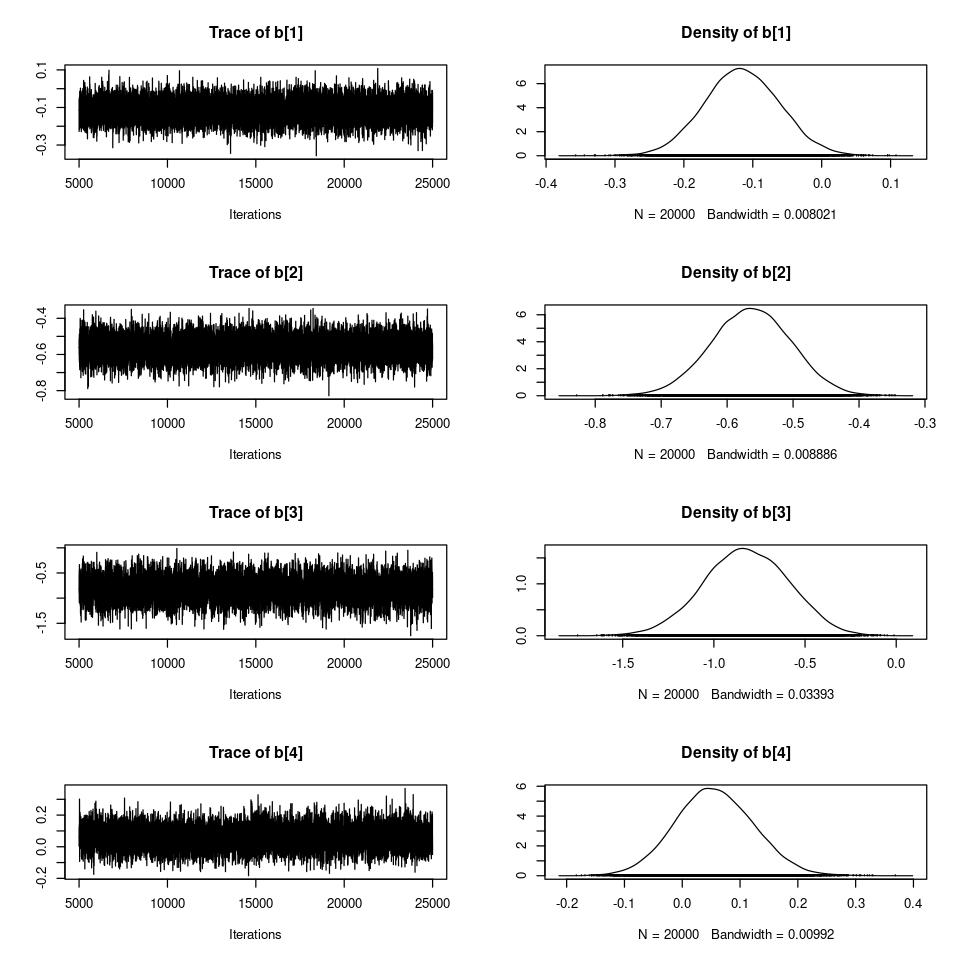

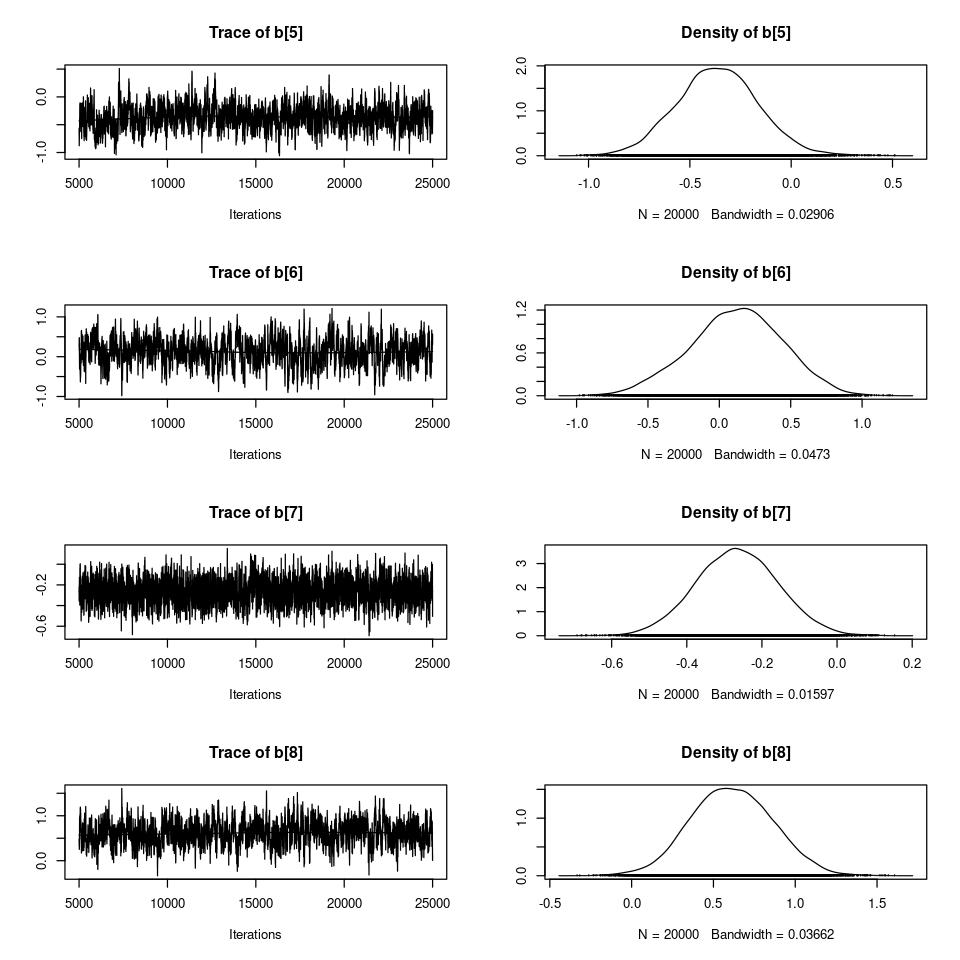

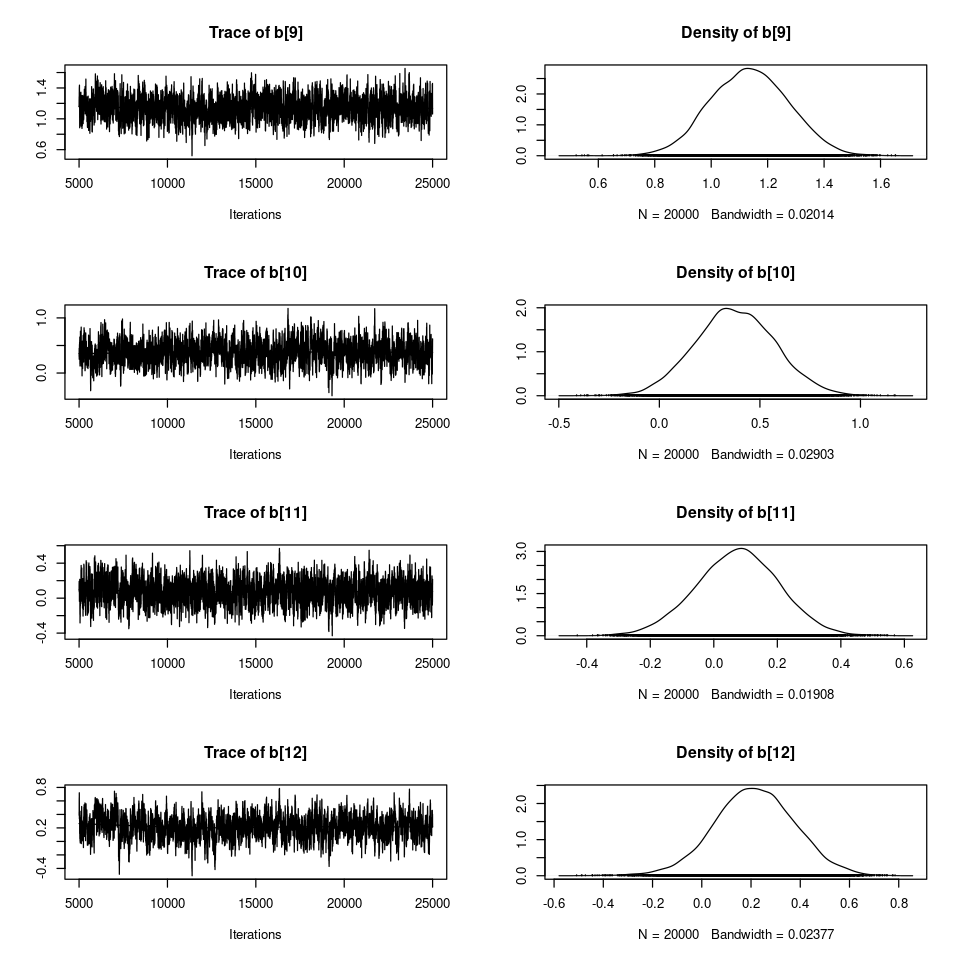

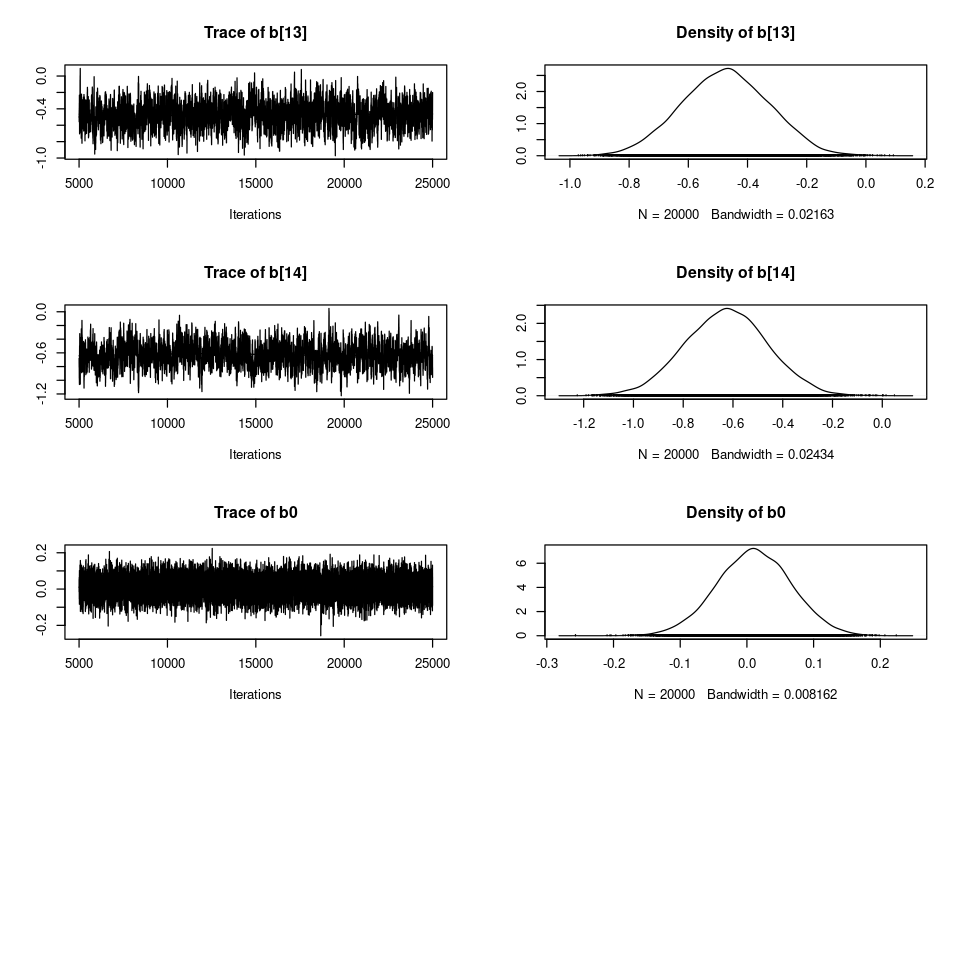

In [90]:
plot(sample.03)

The overall noisy traceplots show that posteriors are correctly sampled.

To check for consistency among initial subsamples, we look at the mean posterior values of the logistic parameters ($\beta_0$ and $\beta$) for each of them. As several times before, we define a function to do it:

In [91]:
logistic.params<-function(sample){
    #retrieve expected values of logistic regression params (the method in 
    # week12/GLM.01.Logistic.Challenger.ipynb does not work here because the 
    #JAGS object is different)
    stats<-summary(sample)$statistics
    a<-stats[19,1]
    b<-c()
    for (i in 5:18){
        b[i-4]<-stats[i,1]
        }
   return(list("b0"=a, "b"=b))
}

In [92]:
logistic.params(sample.01)
logistic.params(sample.02)
logistic.params(sample.03)

$b0
[1] 0.03357818

$b
 [1] -0.06476644 -0.61029888 -0.61702942  0.05605888 -0.53364105 -0.32006011
 [7] -0.22609780  0.71929868  1.27363703  0.59246918  0.37561088  0.31294612
[13] -0.45755707 -0.78005469

$b0
[1] 0.04097049

$b
 [1] -0.001367456 -0.682274253 -0.405347132  0.038023498 -0.222173442
 [6] -0.218368142 -0.078943415  0.961164171  1.374186982  0.368993707
[11]  0.002868829  0.205075370 -0.479366091 -0.555014701

$b0
[1] 0.01073979

$b
 [1] -0.11554372 -0.56366570 -0.82264343  0.05620940 -0.36314839  0.11937457
 [7] -0.26573856  0.61288695  1.13656490  0.37666614  0.07541157  0.21457931
[13] -0.47438376 -0.62677398

In [93]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

Although there is some variability, the posterior means are more or less consistent across subsamples, even if less than for the completely random undersampling. This is puzzling, as the room for randomness is less here than before (a chunk of the dataset is removed by the OSS criterion, which should in principle yield more consistency).

It is worth noting $\beta_{4}$ (coefficient for **B_DIRA_OWNPV**) is still suppressed, along with the intercept $\beta_{0}$.

### 2.2. Evaluation

As before, to evaluate the model, we consider the train and test deviance, AIC, BIC, AUC and recall (focusing on the last 2). 

Note that for the test we use all samples not included in the corresponding 2000 train subsample, so **we test with about 210 000 samples** each time. We do this to put to use all available information, and we can afford to do so at test because we are just evaluating the logistic function (what took so long at train was the MCMC sampling).

Since, once again, we wil do this several times, we define a function to compute and print all relevant evaluation metrics. In the case of the train phase, we also print the deviance, AIC and BIC computed by JAGS, for reference.

In [94]:
evaluate<-function(sample, x, y, phase, threshold=NULL){
    n<-dim(x)[1]
    n.pars<-dim(x)[2]+1 # includes intercept
    
    #retrieve expected values of logistic regression params (the method in 
    # week12/GLM.01.Logistic.Challenger.ipynb does not work here because the JAGS object is different)
    stats<-summary(sample)$statistics
    a<-stats[19,1]
    b<-c()
    for (i in 5:18){
        b[i-4]<-stats[i,1]
        }
    #probabilities
    eta.bar<-as.numeric(a+b%*%t(x))
    p.bar<-1/(1+exp(-eta.bar))
    #log-likelihood
    logL.hat<-sum(y * log(p.bar) + (1 - y) * log(1 - p.bar))
    #AUC
    roc_obj <- roc(y, p.bar)
    AUC.hat<-auc(roc_obj)
    cat("\n", phase,"AUC:", round(AUC.hat,4)) 
    #deviance
    D.hat<- -2*logL.hat
    cat("\n", phase,"Deviance:", round(D.hat,4))  
    #AIC
    AIC.hat<-D.hat+2*n.pars
    cat("\n", phase,"AIC:", round(AIC.hat,4))  
    #BIC
    BIC.hat<-D.hat+log(n)*n.pars
    cat("\n", phase,"BIC:", round(BIC.hat,4))  
    #if training phase, print JAGS quantities as well for comparison
    if (phase=="train"){
        aic<-stats[1,1]
        bic<-stats[2,1]
        dev<-stats[3,1]
        cat("\n JAGS Deviance:", round(dev,4))  
        cat("\n JAGS AIC:", round(aic,4))  
        cat("\n JAGS BIC:", round(bic,4))   
        #compute threshold and recall/sensitivity for best operating point
        #in train ROC curve, also plotting the curve
        rc <- ROC(test=p.bar, stat = as.logical(y), plot="ROC", main="Train ROC curve") 
        opt <- which.max(rowSums(rc$res[, c("sens", "spec")]))
        # optimal cut-off point and corresponding recall
        threshold = as.numeric(names(opt))
        recall<-rc$res$sens[opt]
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
        return(threshold)
        } else{
        # for true positives, y=1 and p.bar>threshold, so y+p.bar>1+threshold
        check<-y+p.bar 
        true.p<-0
        total.p<-sum(y)
        for (num in check){
            if (num >= (1+threshold)){
            true.p<-true.p+1    
            }
        }
        #print test recall
        recall<-true.p/total.p
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
            
        }
    
    }

Having our function, we call it for the result obtained for each original subsample:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.817
 train Deviance: 2106.276
 train AIC: 2136.276
 train BIC: 2220.29
 JAGS Deviance: 2121.267
 JAGS AIC: 2151.267
 JAGS BIC: 2235.28
 train recall/sensitivity 0.735

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7899
 test Deviance: 254212.2
 test AIC: 254242.2
 test BIC: 254396
 test recall/sensitivity 0.7825

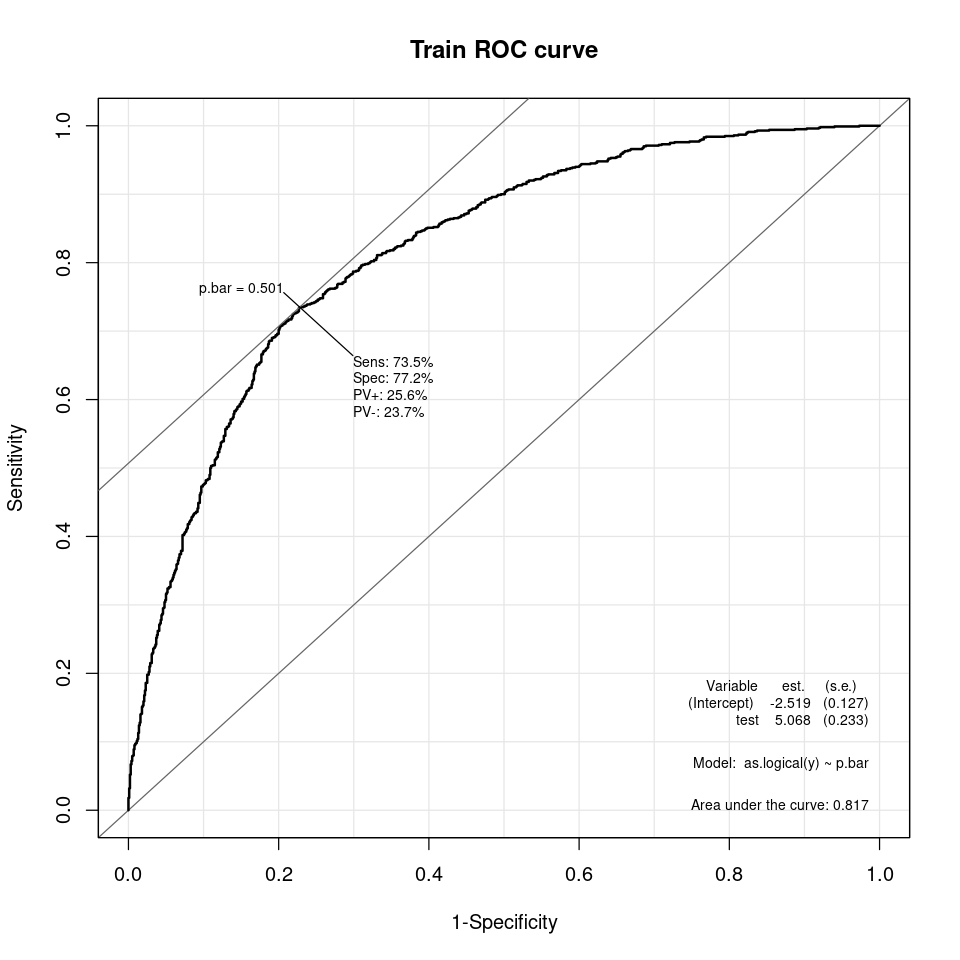

In [95]:
#evaluate train
thr<-evaluate(sample.01, x0.01, y.01, phase="train")
# evaluate test
xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8343
 train Deviance: 2025.797
 train AIC: 2055.797
 train BIC: 2139.811
 JAGS Deviance: 2040.777
 JAGS AIC: 2070.777
 JAGS BIC: 2154.79
 train recall/sensitivity 0.796

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7885
 test Deviance: 258759.6
 test AIC: 258789.6
 test BIC: 258943.5
 test recall/sensitivity 0.8161

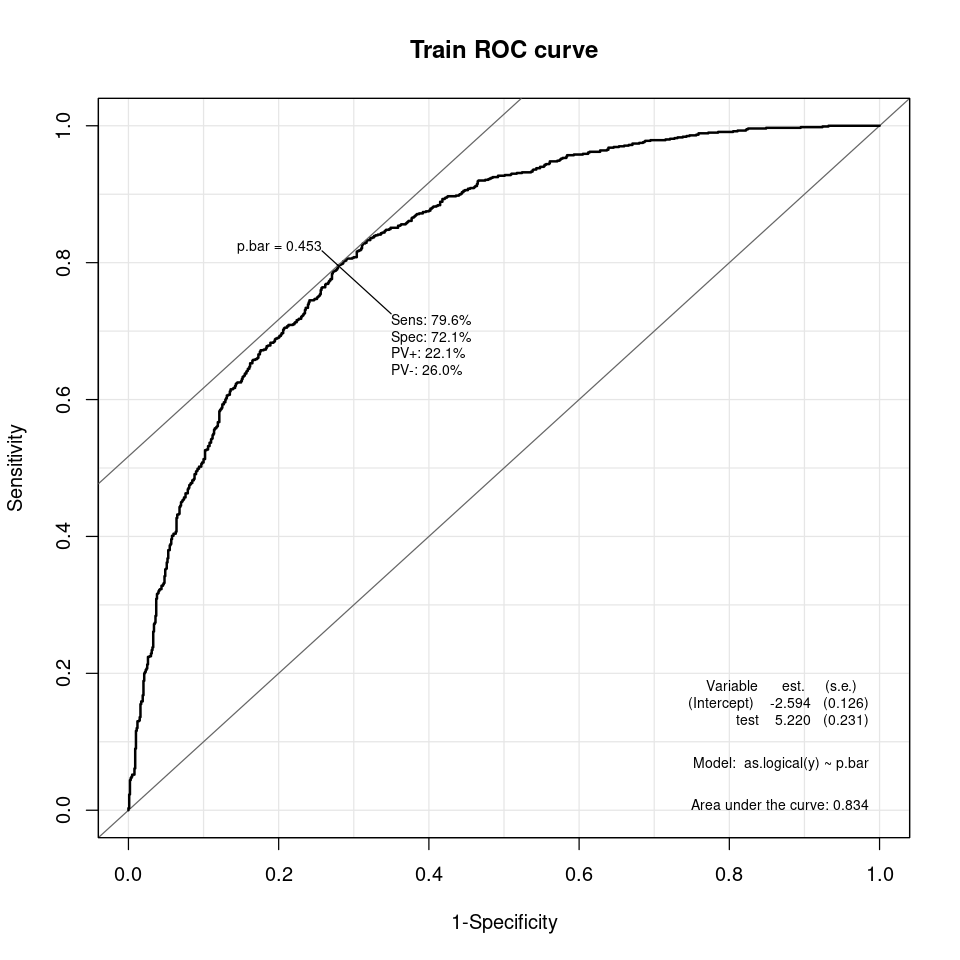

In [96]:
thr<-evaluate(sample.02, x0.02, y.02, phase="train")

xt<-model.matrix(Response~.,test.02)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.02$Response
evaluate(sample.02, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8175
 train Deviance: 2081.755
 train AIC: 2111.755
 train BIC: 2195.769
 JAGS Deviance: 2096.879
 JAGS AIC: 2126.879
 JAGS BIC: 2210.892
 train recall/sensitivity 0.818

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7878
 test Deviance: 254351.8
 test AIC: 254381.8
 test BIC: 254535.7
 test recall/sensitivity 0.8594

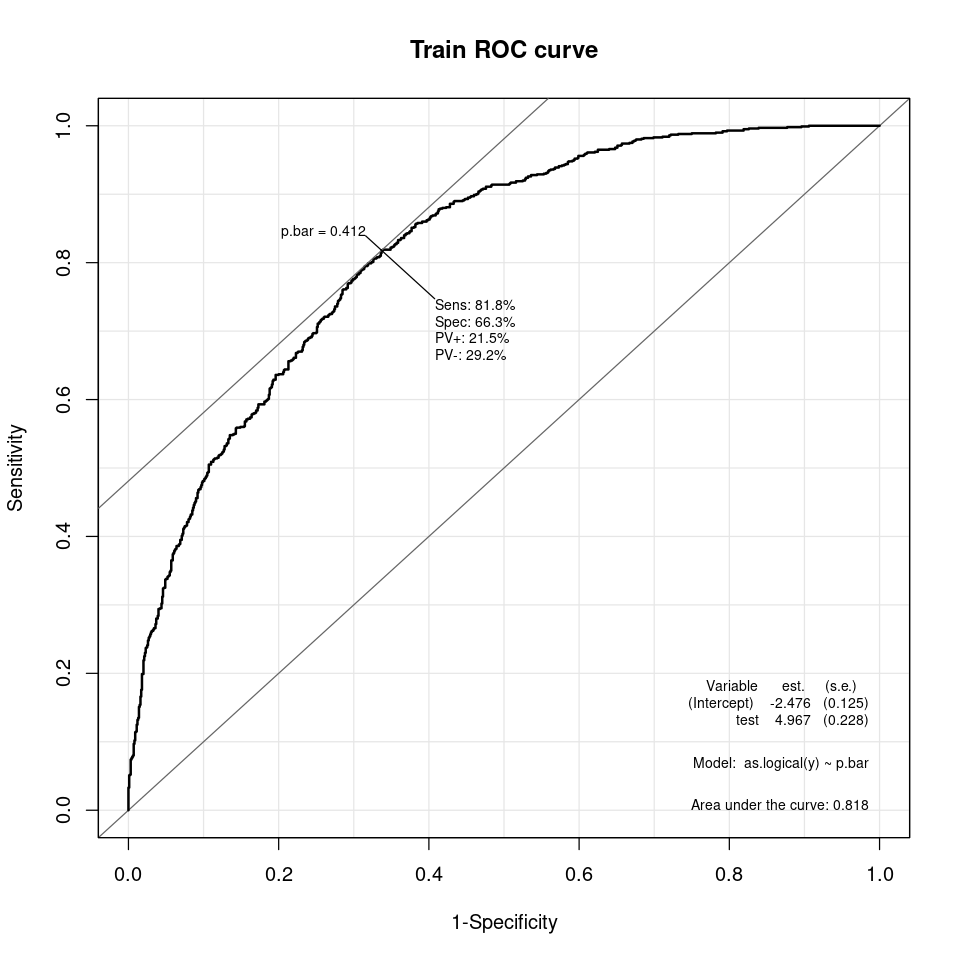

In [97]:
thr<-evaluate(sample.03, x0.03, y.03, phase="train")

xt<-model.matrix(Response~.,test.03)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.03$Response
evaluate(sample.03, xt, yt, phase="test", threshold = thr)

We get similar test AUCs across subsamples (0.79), while test recall varies from 0.78 to 0.86 (a slightly greater upper bound than with completely random undersampling). The lack of significant effect probably comes, as anticipated, from the fact that only a fraction of the total dataset is selectively removed, the majority still being randomly trimmed.

The similarity across subsamples contributes to validating their size, with a caveat on the recall.

Let us now chheck the one-step removal with the Neighbourhood Cleaning Rule.

## 3. Neighbourhood Cleaning Rule

Just by changing the method of our previously defined function for subsampling, we can obtain the 3 new subsamples:

In [98]:
method="ncr"
nh<-1000#50

In [99]:
subsample.01 <- subsample.balanced.2(data, method=method, nh=nh, seed=4)
train.01<-subsample.01$train
test.01<-subsample.01$test
#str(train.01)
#str(test.01)
subsample.02 <- subsample.balanced.2(data, method=method, nh=nh, seed=44)
train.02<-subsample.02$train
test.02<-subsample.02$test

subsample.03 <- subsample.balanced.2(data, method=method, nh=nh, seed=444)
train.03<-subsample.03$train
test.03<-subsample.03$test


NCR undersampling:
Number of instances removed from majority class with ENN: 6599 	 Time needed: 36.37 
Number of instances removed from majority class after ENN: 38785 	 Time needed: 20.34 
Number of instances removed from majority class: 45384 
Train size = 2000 
Test size = 210662 
Train signal fraction = 0.5
NCR undersampling:
Number of instances removed from majority class with ENN: 6599 	 Time needed: 32.11 
Number of instances removed from majority class after ENN: 38785 	 Time needed: 16.27 
Number of instances removed from majority class: 45384 
Train size = 2000 
Test size = 210662 
Train signal fraction = 0.5
NCR undersampling:
Number of instances removed from majority class with ENN: 6599 	 Time needed: 31.95 
Number of instances removed from majority class after ENN: 38785 	 Time needed: 16.16 
Number of instances removed from majority class: 45384 
Train size = 2000 
Test size = 210662 
Train signal fraction = 0.5

And format them for JAGS:

In [100]:
# Convert factors to one-hot indicators
x.01<-model.matrix(Response~.,train.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
y.01<-train.01$Response
#check x.01 is indeed ohe'd (eg see "Vehicle_Age")
#head(x.01)
x.02<-model.matrix(Response~.,train.02)[,-1] 
y.02<-train.02$Response

x.03<-model.matrix(Response~.,train.03)[,-1] 
y.03<-train.03$Response

Standardise the data:

In [102]:
x0.01<-standardise(x.01)
x0.02<-standardise(x.02)
x0.03<-standardise(x.03)
#head(x0.01)
# check that all vertical means of x0.01 are indeed 0
round(max(abs(apply(x0.01,2,mean))),6) 
# check that indeed sd's of columns of x0.01 are 1
round(apply(x0.01,2,sd), 5)

[1] 0

B_OWNPV_CHI2      B_IPCHI2_OWNPV      B_FDCHI2_OWNPV        B_DIRA_OWNPV 
                  1                   1                   1                   1 
               B_PT  Kst_892_0_IP_OWNPV Kst_892_0_cosThetaH      Kplus_IP_OWNPV 
                  1                   1                   1                   1 
            Kplus_P    piminus_IP_OWNPV           piminus_P            gamma_PT 
                  1                   1                   1                   1 
        piminus_ETA           Kplus_ETA 
                  1                   1

The condition number $\kappa$ is indeed much smaller after standardisation, meaning a more stable regression:

In [103]:
#have to take the intercept into account as well for the condition number
x1.01<-cbind(rep(1,n),x.01)
x01.01<-cbind(rep(1,n),x0.01)
round(kappa(x1.01),1)
round(kappa(x01.01),1)

[1] 1146093036

[1] 15.2

### 3.1. Modelling

No need to redefine the JAGS *model_string*, as it is the same as the one used with OSS.

Define parameters and data (this one for each initial subsample), and the corresponding models:

In [104]:
n<-length(y.01)
p=dim(x0.01)[2]
params <- c("b0", "b", "LogL", "AIC", "BIC", "Deviance")

data.01 <- list(y = y.01, X = x0.01, n_pars = p, n = n, logn=log(n))
data.02 <- list(y = y.02, X = x0.02, n_pars = p, n = n, logn=log(n))
data.03 <- list(y = y.03, X = x0.03, n_pars = p, n = n, logn=log(n))


In [105]:
model.01<-jags.model(textConnection(model_string),data=data.01)
model.02<-jags.model(textConnection(model_string),data=data.02)
model.03<-jags.model(textConnection(model_string),data=data.03)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2000
   Unobserved stochastic nodes: 15
   Total graph size: 56034

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2000
   Unobserved stochastic nodes: 15
   Total graph size: 56034

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2000
   Unobserved stochastic nodes: 15
   Total graph size: 56034

Initializing model



Run one chain per model with 20 000 iterations and a burnout of the 5000 (see summary(sample.01)) initial samples (those that will be discarded to assure randomness of MCMC sampling). Note that this takes around 40 min for each of the three subsamples.

We could have defined initial values for the parameters, but as we have seen in the course JAGS can make a judicious choice thereof from the data, so we let it do it for us.

In [106]:
update(model.01, 4000, progress.bar = "gui")
update(model.02, 4000, progress.bar = "gui")
update(model.03, 4000, progress.bar = "gui")

In [107]:
start.time <- Sys.time()

sample.01<-coda.samples(model.01, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 36.9725 mins

In [108]:
start.time <- Sys.time()

sample.02<-coda.samples(model.02, variable.names = params,
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 40.95376 mins

In [109]:
start.time <- Sys.time()

sample.03<-coda.samples(model.03, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 35.43865 mins

Visualise output:

In [110]:
summary(sample.01)


Iterations = 5001:25000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean      SD  Naive SE Time-series SE
AIC       2.248e+03 5.53816 0.0391607      0.1107057
BIC       2.332e+03 5.53816 0.0391607      0.1107057
Deviance  2.218e+03 5.53816 0.0391607      0.1107057
LogL     -1.109e+03 2.76908 0.0195803      0.0553528
b[1]     -5.926e-02 0.05425 0.0003836      0.0005198
b[2]     -5.548e-01 0.05698 0.0004029      0.0005885
b[3]     -1.209e-01 0.09190 0.0006498      0.0018030
b[4]      6.541e-02 0.06689 0.0004730      0.0009087
b[5]     -2.697e-01 0.19878 0.0014056      0.0093323
b[6]      3.800e-01 0.31037 0.0021946      0.0182599
b[7]     -1.595e-01 0.09678 0.0006843      0.0027454
b[8]      2.489e-01 0.25070 0.0017727      0.0134649
b[9]      1.101e+00 0.13925 0.0009847      0.0050731
b[10]     1.704e-01 0.17209 0.0012169      0.0070174
b[11] 

In [111]:
#summary(sample.02)

In [112]:
#summary(sample.03)

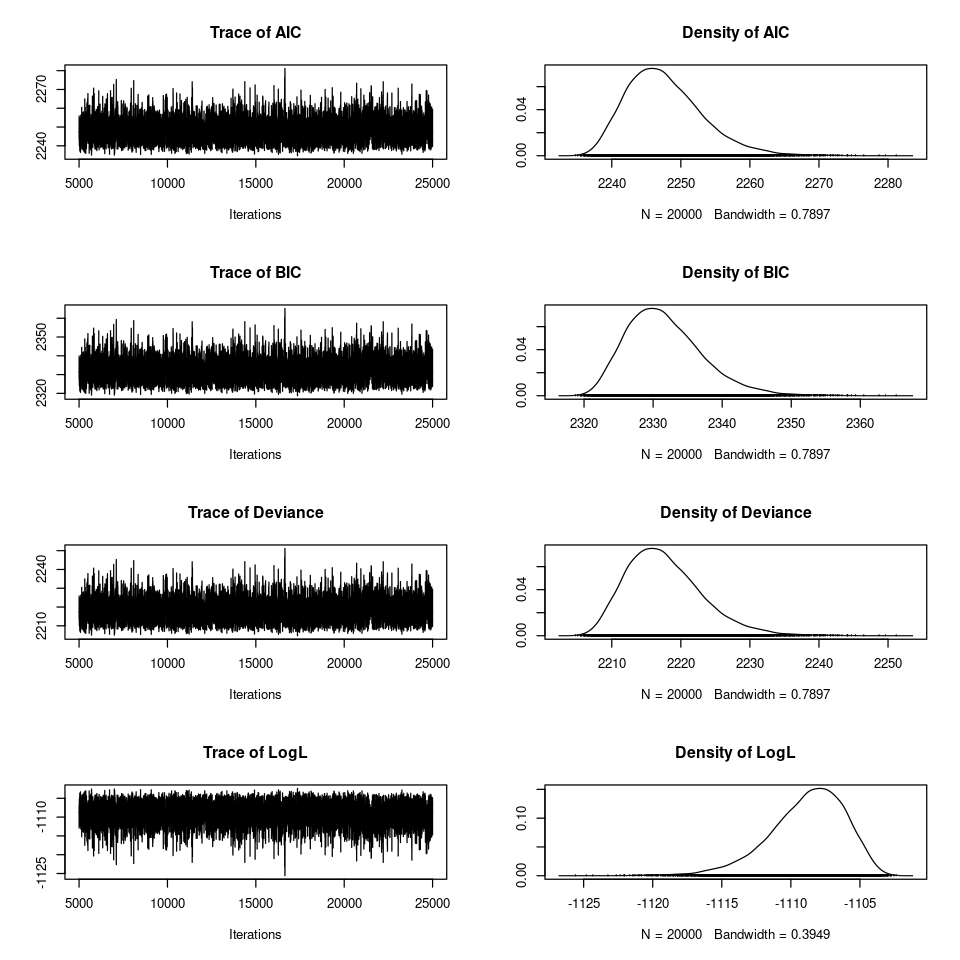

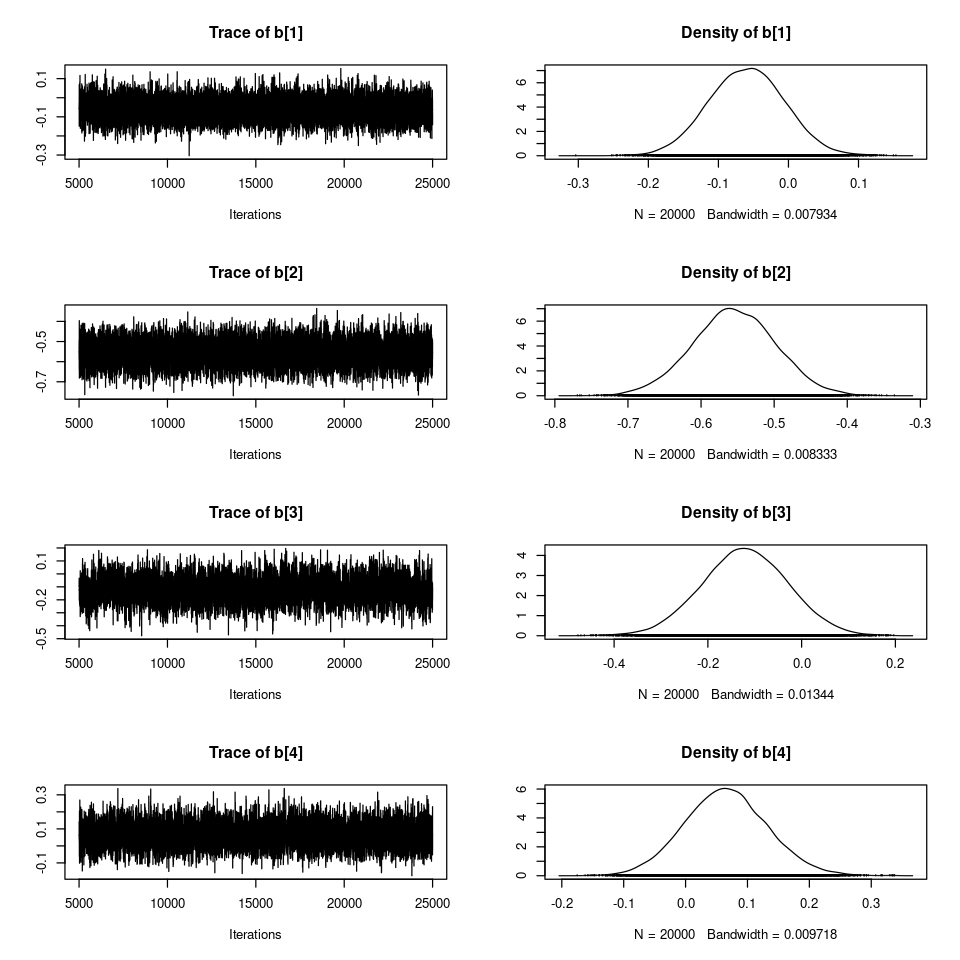

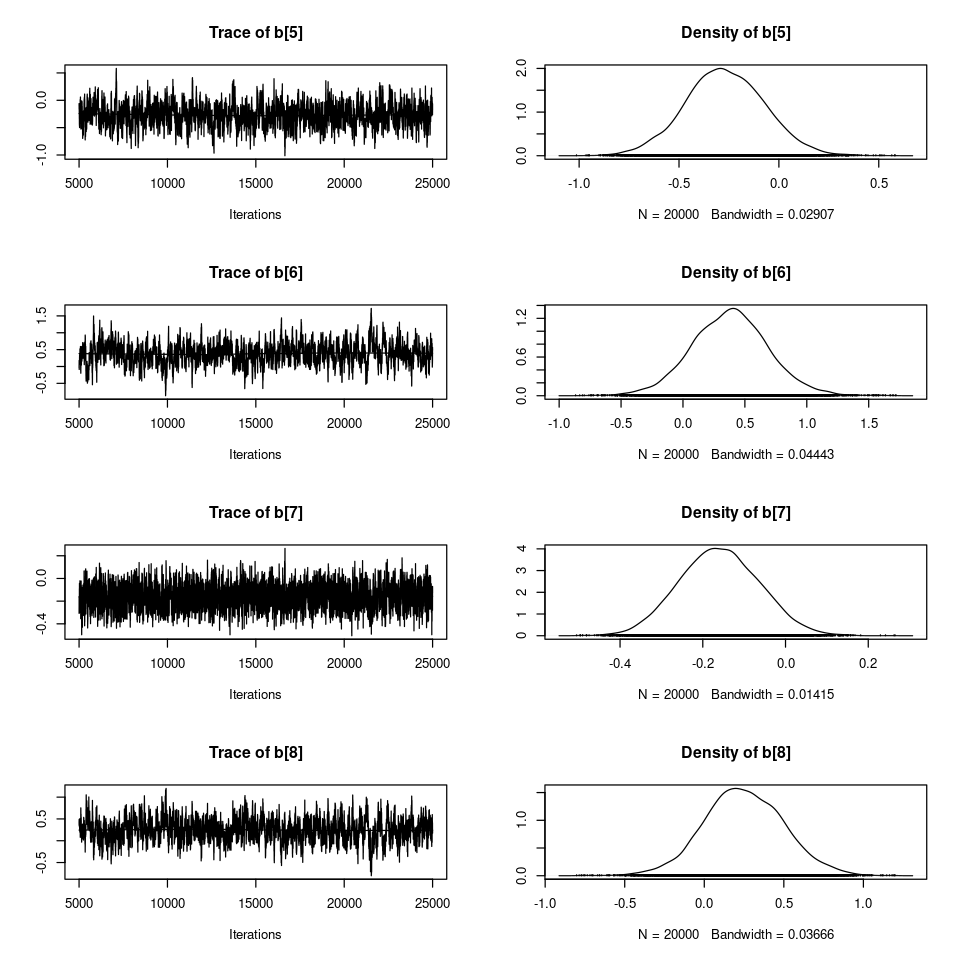

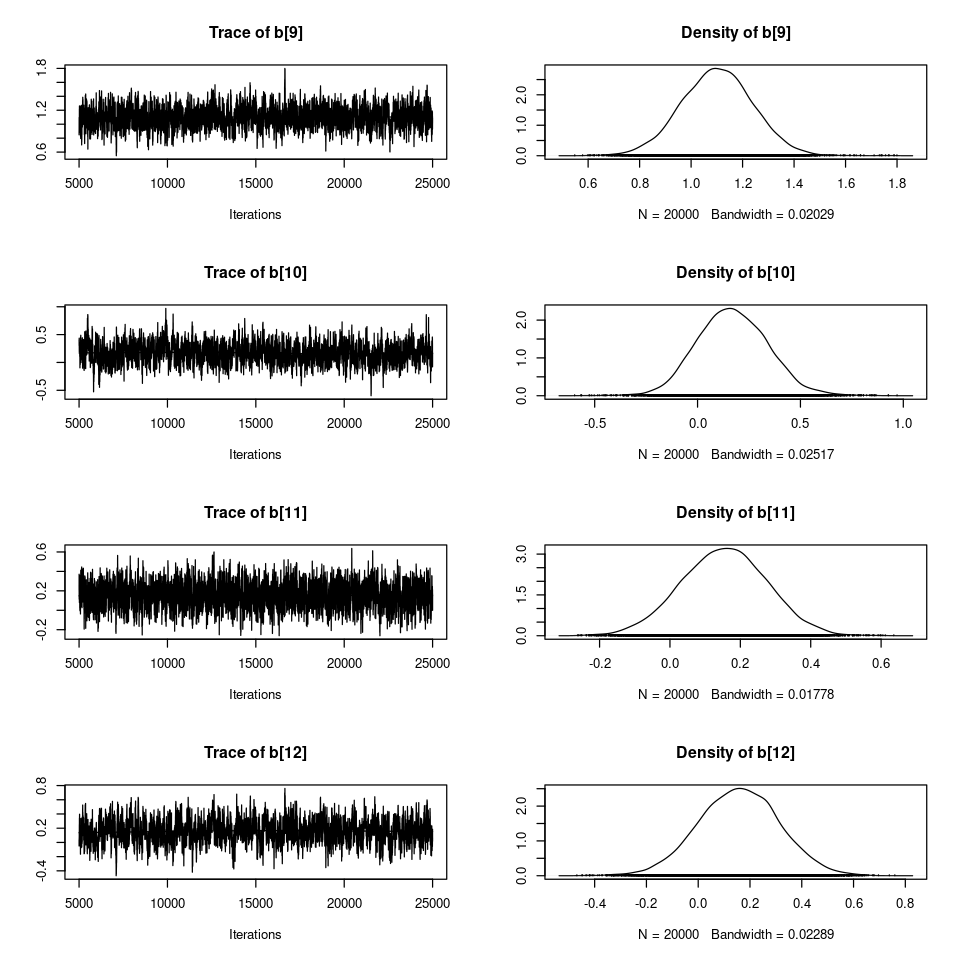

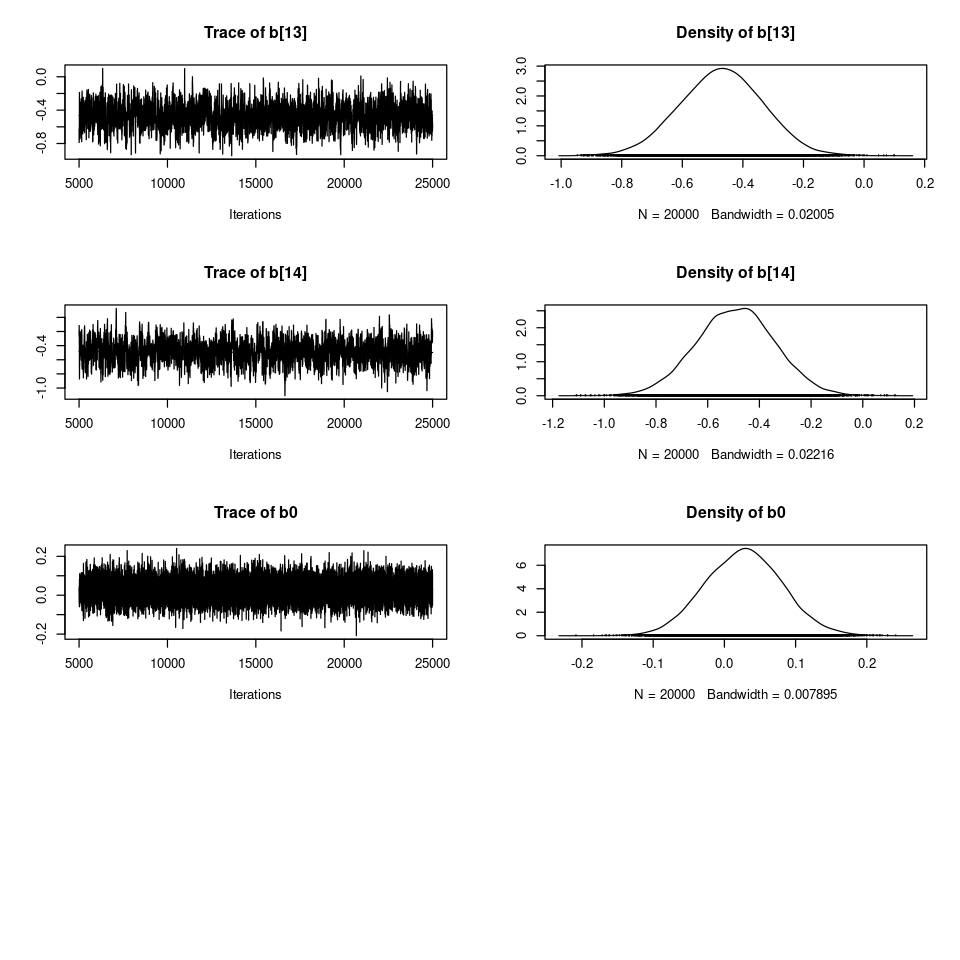

In [113]:
plot(sample.01)

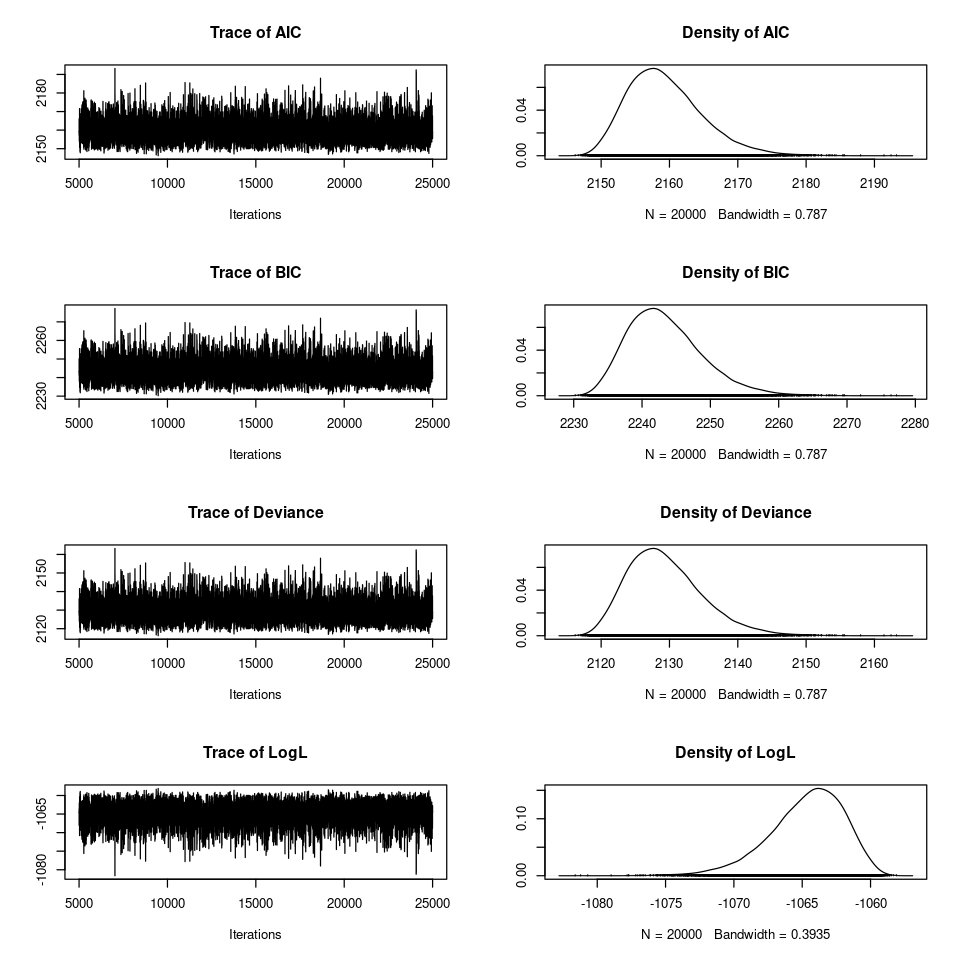

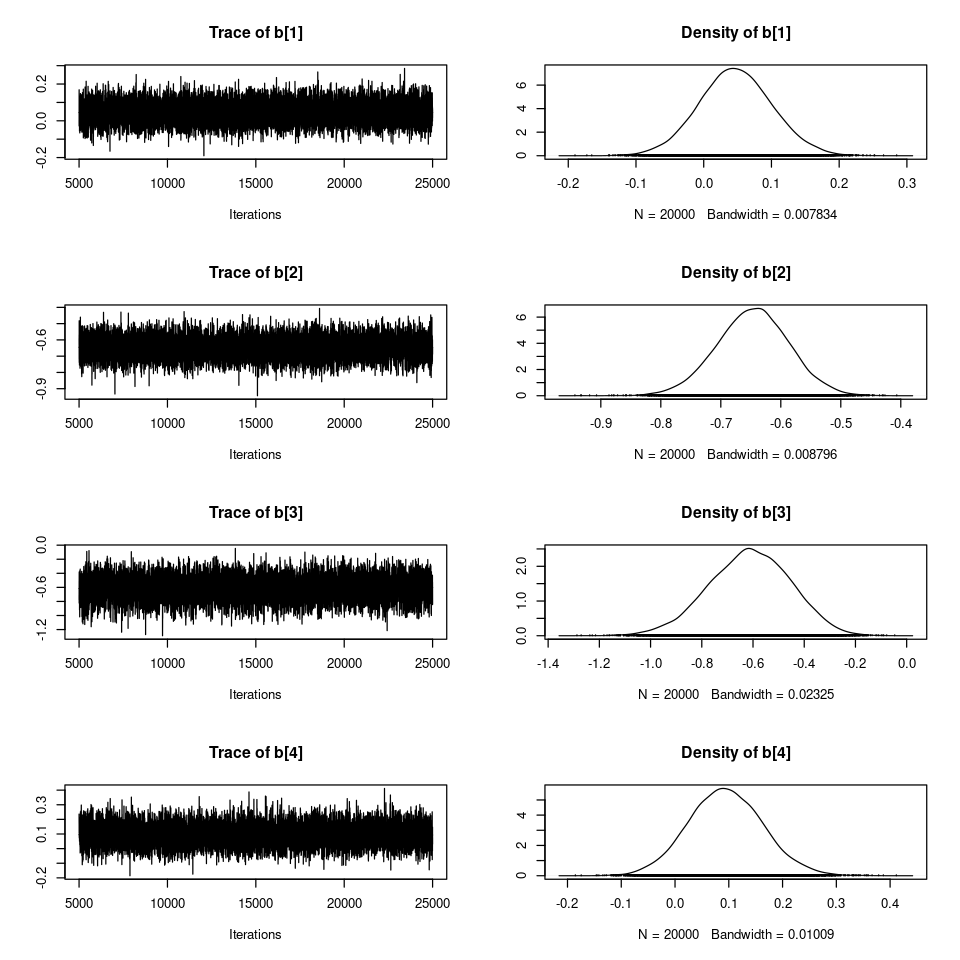

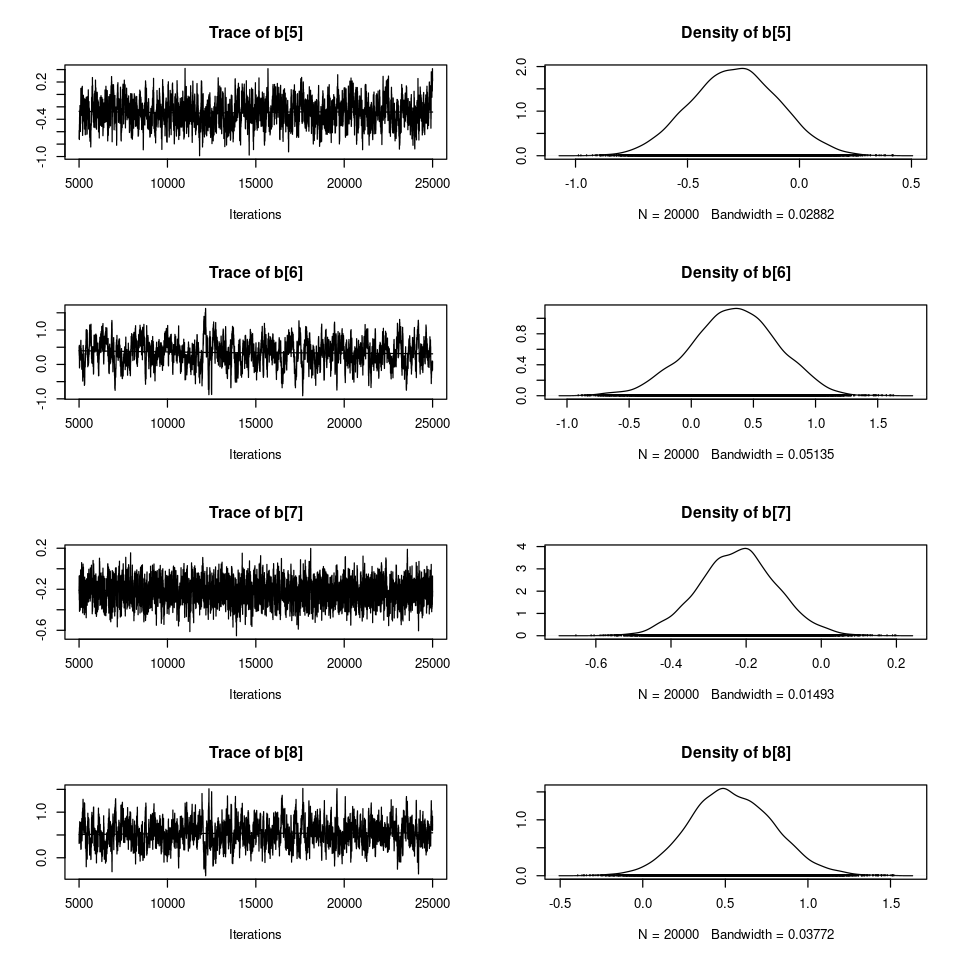

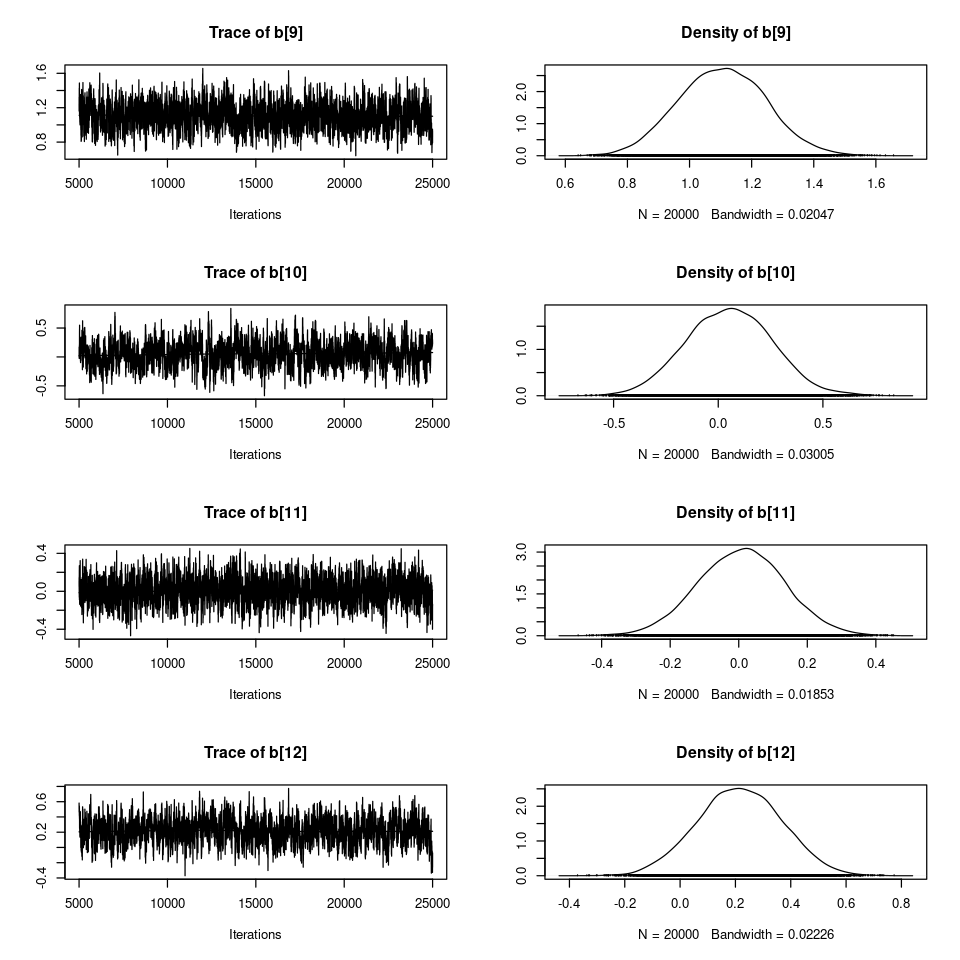

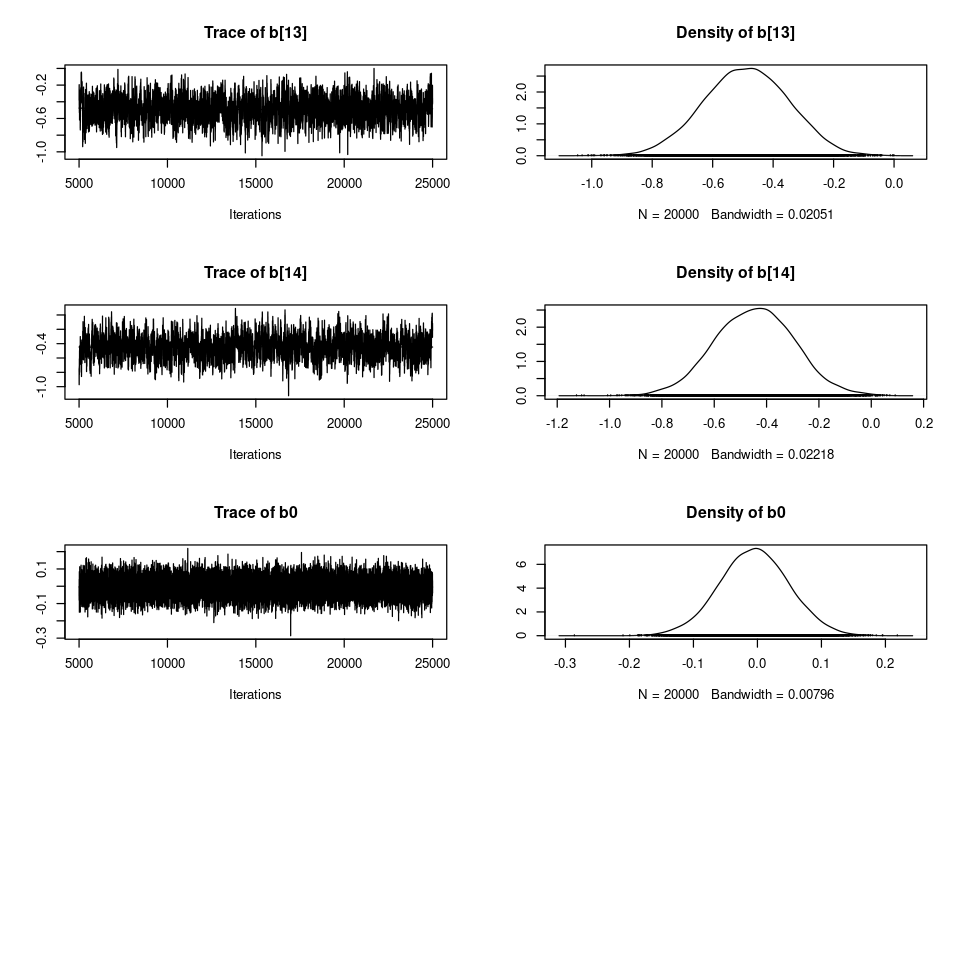

In [114]:
plot(sample.02)

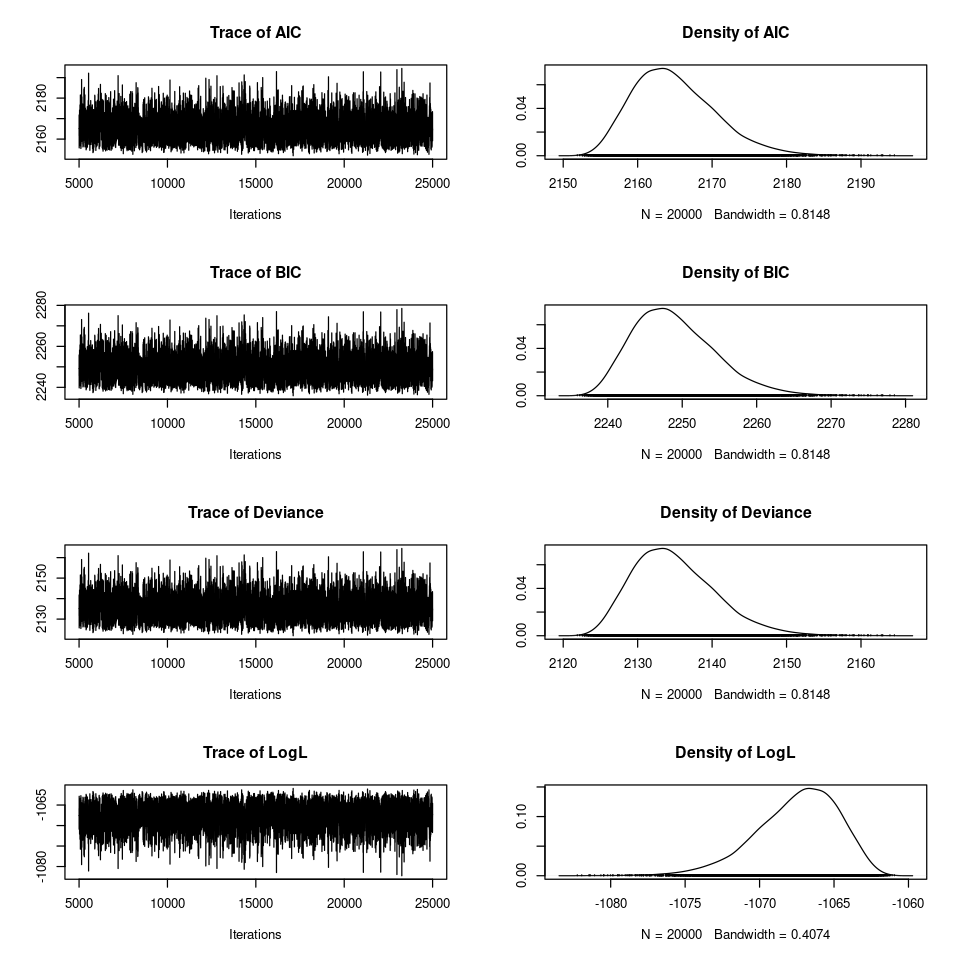

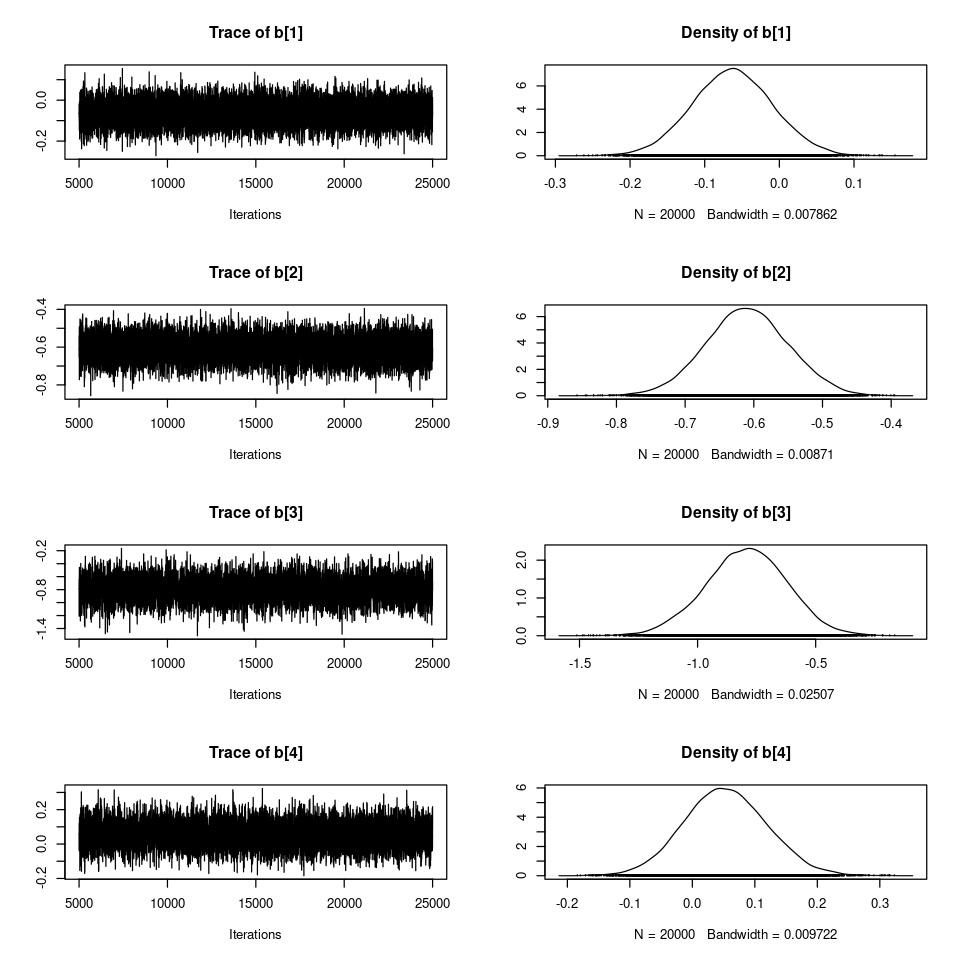

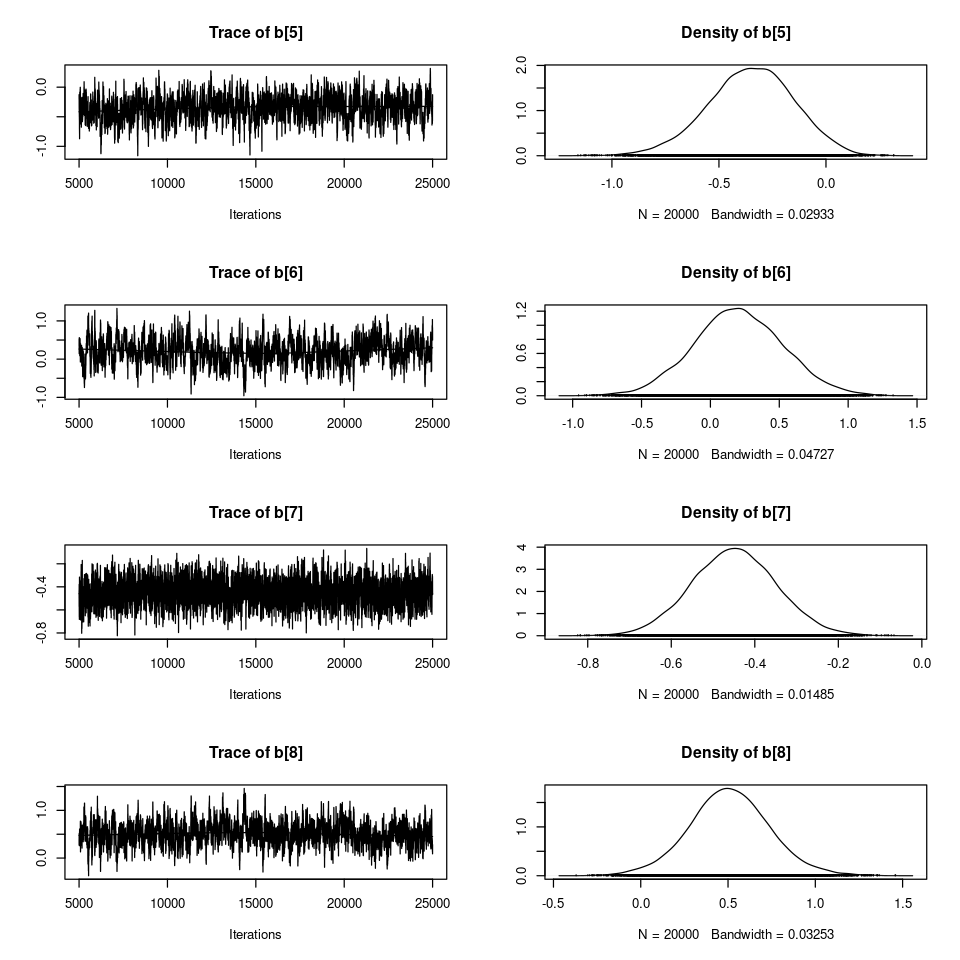

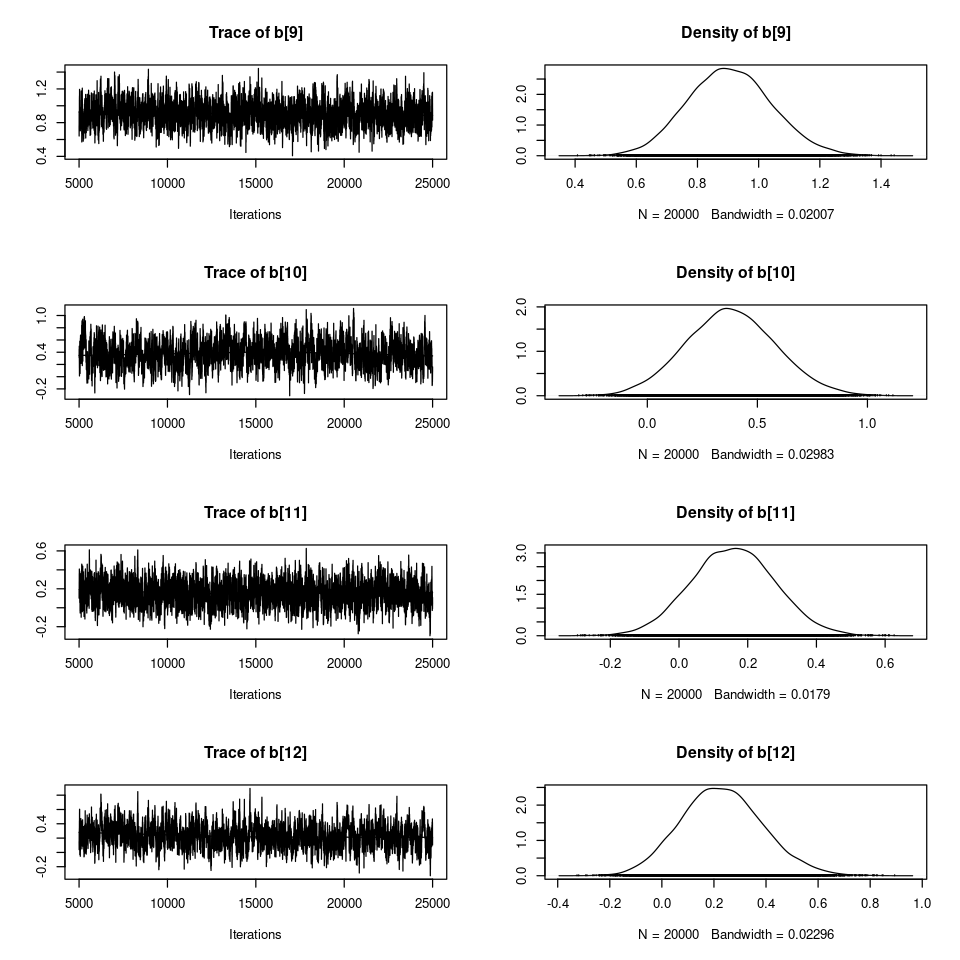

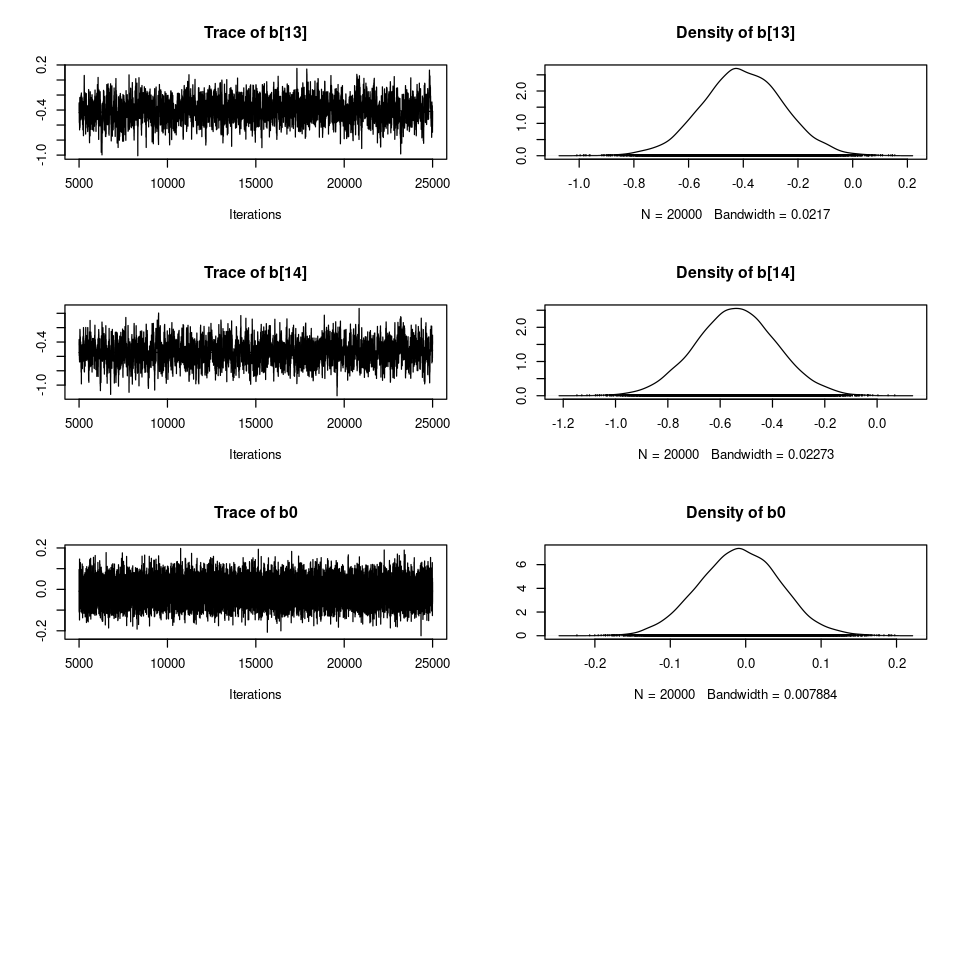

In [115]:
plot(sample.03)

As in the previous case, the overall noisy traceplots show that posteriors are correctly sampled.

Check the logistic parameters ($\beta_0$ and $\beta$) for consistency:

In [116]:
logistic.params(sample.01)
logistic.params(sample.02)
logistic.params(sample.03)

$b0
[1] 0.02730236

$b
 [1] -0.05925789 -0.55477450 -0.12085475  0.06540881 -0.26972847  0.38000858
 [7] -0.15954262  0.24886310  1.10133667  0.17037545  0.15363415  0.15741013
[13] -0.47044971 -0.49217468

$b0
[1] -0.004706528

$b
 [1]  0.047144040 -0.646632910 -0.613126105  0.094382356 -0.287584691
 [6]  0.338481784 -0.221900180  0.538652853  1.105850998  0.053454992
[11]  0.007927628  0.215341717 -0.489131493 -0.445903945

$b0
[1] -0.00780998

$b
 [1] -0.06268561 -0.60963770 -0.79361031  0.05344538 -0.35070043  0.20312634
 [7] -0.44915474  0.50929614  0.90613025  0.38011640  0.15748191  0.23095887
[13] -0.40210163 -0.53937959

In [117]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

Although there is some variability, the posterior means are more or less consistent across subsamples (a bit more than in the OSS case, it seems). 

$\beta_{4}$ (coefficient for **B_DIRA_OWNPV**) is still supressed, along with $\beta_{1}$ (**B_OWNPV_CHI2**, which was not supressed in all subsamples of the OSS nor the completely random cases) and the intercept $\beta_0$.

### 3.2. Evaluation

We use the function defined in **2.2**:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7929
 train Deviance: 2202.621
 train AIC: 2232.621
 train BIC: 2316.634
 JAGS Deviance: 2217.672
 JAGS AIC: 2247.672
 JAGS BIC: 2331.685
 train recall/sensitivity 0.781

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7894
 test Deviance: 250949.3
 test AIC: 250979.3
 test BIC: 251133.2
 test recall/sensitivity 0.8307

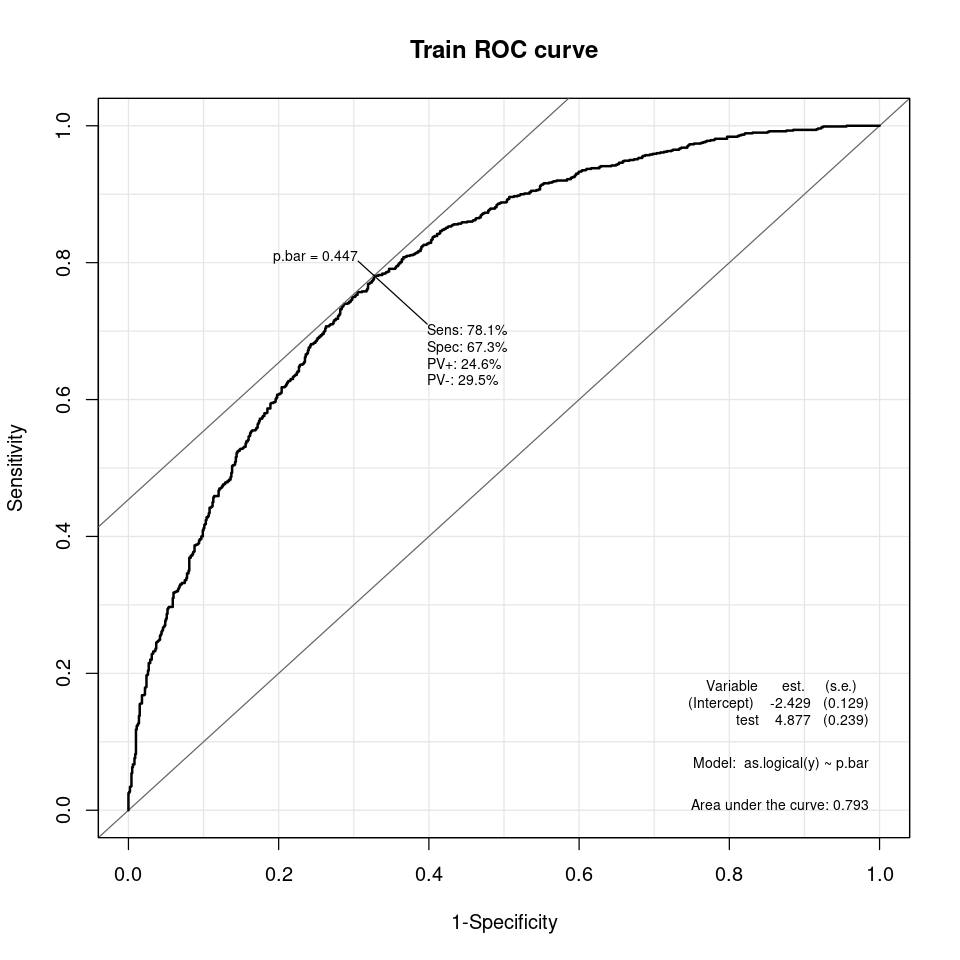

In [118]:
#evaluate train
thr<-evaluate(sample.01, x0.01, y.01, phase="train")
# evaluate test
xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8146
 train Deviance: 2114.46
 train AIC: 2144.46
 train BIC: 2228.474
 JAGS Deviance: 2129.387
 JAGS AIC: 2159.387
 JAGS BIC: 2243.401
 train recall/sensitivity 0.759

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7886
 test Deviance: 251896.9
 test AIC: 251926.9
 test BIC: 252080.8
 test recall/sensitivity 0.796

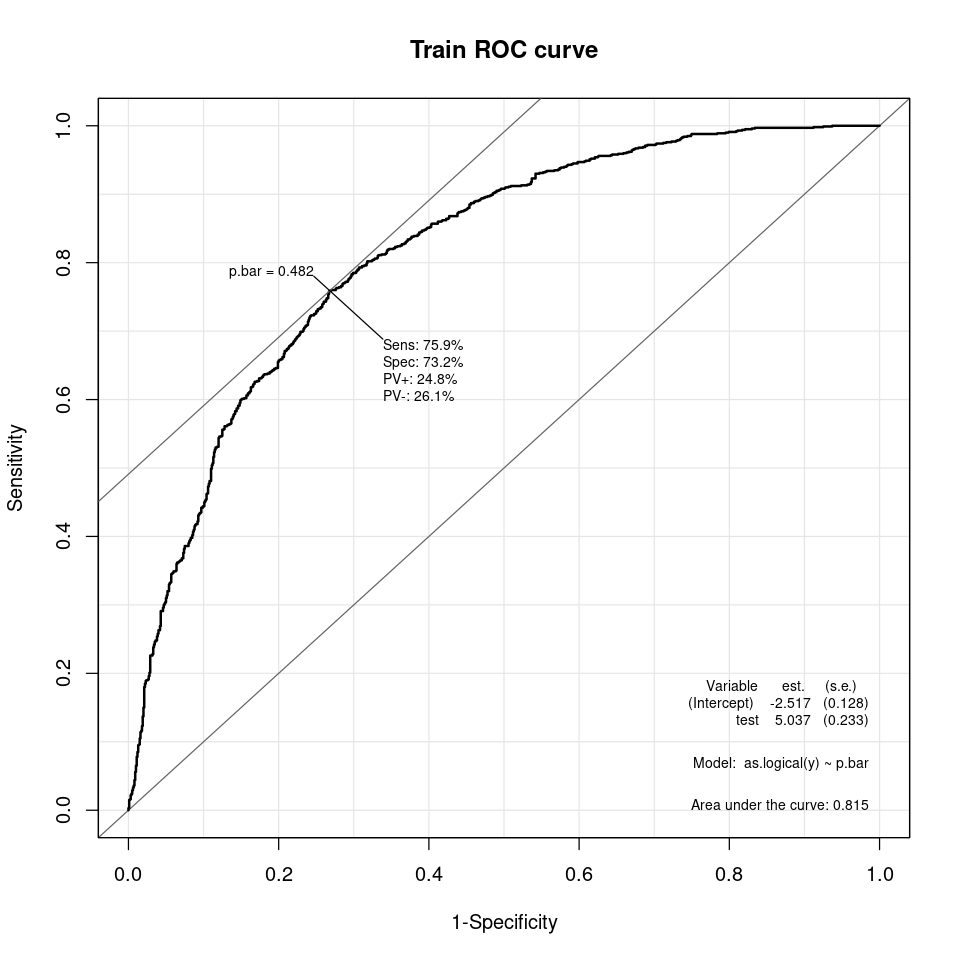

In [119]:
thr<-evaluate(sample.02, x0.02, y.02, phase="train")

xt<-model.matrix(Response~.,test.02)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.02$Response
evaluate(sample.02, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8109
 train Deviance: 2119.806
 train AIC: 2149.806
 train BIC: 2233.82
 JAGS Deviance: 2134.971
 JAGS AIC: 2164.971
 JAGS BIC: 2248.984
 train recall/sensitivity 0.765

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7859
 test Deviance: 253228.4
 test AIC: 253258.4
 test BIC: 253412.3
 test recall/sensitivity 0.8067

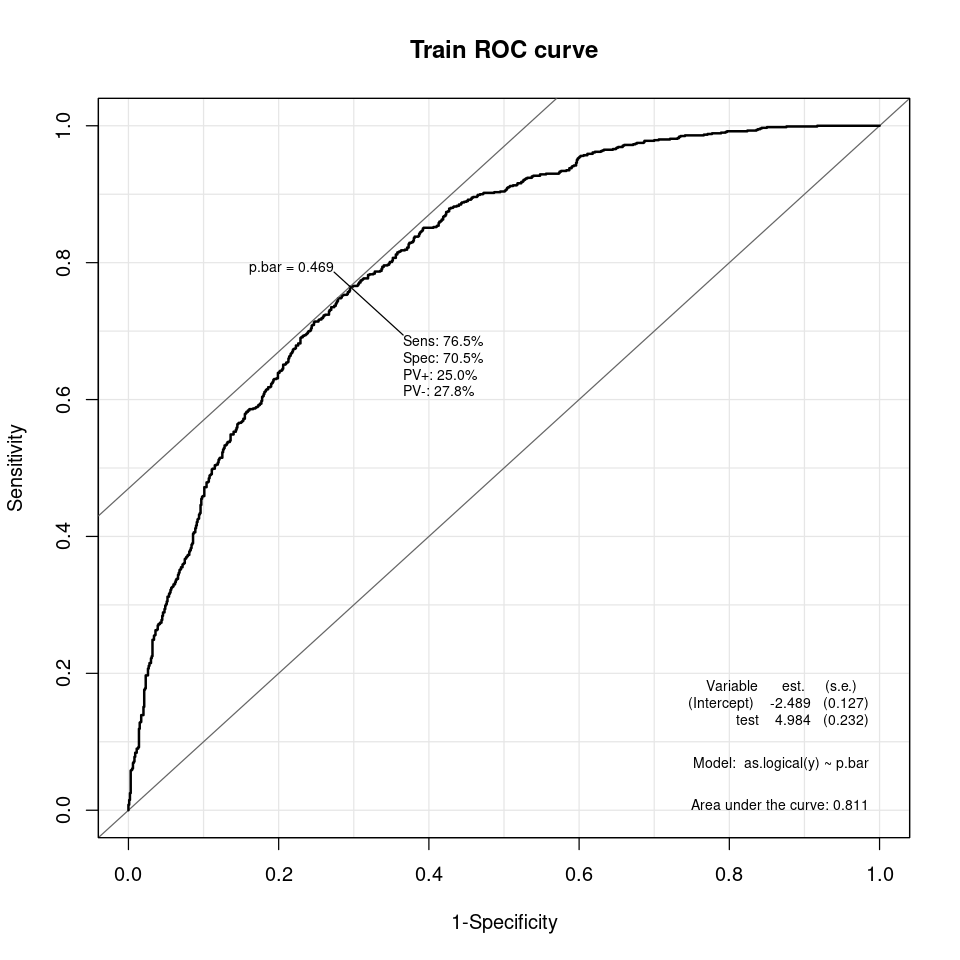

In [120]:
thr<-evaluate(sample.03, x0.03, y.03, phase="train")

xt<-model.matrix(Response~.,test.03)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.03$Response
evaluate(sample.03, xt, yt, phase="test", threshold = thr)

Again, similar test AUCs across subsamples (0.79), while test recall varies from 0.80 to 0.83. Still no significant difference with the baseline, the vanilla logistic regression with completely random undersampling (as with OSS, this was anticipated, since the majority of the dataset is still randomly reduced).

The similarity across subsamples contributes to validating their size.

## 4. Conclusion

The present notebook has confirmeed our intuition that one-step targetted subsampling is not enough in our case. We will see if we can improve the above results with our *Recursive Targetted Removal* method.